# Project Tasks

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should combine the profiles and activities and use each data type independently.
* Implement different models for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier top predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session 

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [168]:
import warnings
import numpy as np
import numpy.random as npr
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from collections import Counter
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning

## Mutational catalogs and activities - WGS data

In [2]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [3]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)
print(set([s.split('::')[0].split('-')[-1] for s in nonPCAWG_wgs_mut.columns[2:]]))

{'Sarcoma', 'GBM', 'Melanoma', 'ALL', 'BNHL', 'AdenoCa', 'CLL', 'bone', 'HCC', 'Medullo', 'LGG', 'CMDI', 'cancer', 'RCC', 'NOS', 'Endocrine', 'Ewings', 'AML'}


In [5]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,...,0,0,0,0,0,0,0,0,0,0


## Mutational catalogs - WES data

In [6]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

,Mutation type,Trinucleotide,AML::TCGA-AB-2802-03B-01W-0728-08,AML::TCGA-AB-2803-03B-01W-0728-08,AML::TCGA-AB-2804-03B-01W-0728-08,AML::TCGA-AB-2805-03B-01W-0728-08,AML::TCGA-AB-2806-03B-01W-0728-08,AML::TCGA-AB-2807-03B-01W-0728-08,AML::TCGA-AB-2808-03B-01W-0728-08,AML::TCGA-AB-2809-03D-01W-0755-09,...,Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08
0,C>A,ACA,0,0,0,0,4,0,2,0,...,1,0,0,0,0,0,0,0,0,0
1,C>A,ACC,0,2,0,0,0,1,3,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,AML,TCGA-AB-2802-03B-01W-0728-08,0.811,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AML,TCGA-AB-2803-03B-01W-0728-08,0.608,4,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

,Mutation type,Trinucleotide,ALL::TARGET-10-PAIXPH-03A-01D,ALL::TARGET-10-PAKHZT-03A-01R,ALL::TARGET-10-PAKMVD-09A-01D,ALL::TARGET-10-PAKSWW-03A-01D,ALL::TARGET-10-PALETF-03A-01D,ALL::TARGET-10-PALLSD-09A-01D,ALL::TARGET-10-PAMDKS-03A-01D,ALL::TARGET-10-PAPJIB-04A-01D,...,Head-SCC::V-109,Head-SCC::V-112,Head-SCC::V-116,Head-SCC::V-119,Head-SCC::V-123,Head-SCC::V-124,Head-SCC::V-125,Head-SCC::V-14,Head-SCC::V-29,Head-SCC::V-98
0,C>A,ACA,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
1,C>A,ACC,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [9]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,TARGET-10-PAIXPH-03A-01D,0.529,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,ALL,TARGET-10-PAKHZT-03A-01R,0.696,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Data cleanup and train-test split

In [12]:
def normalize(data, axis=1):
    """
    Normalize DataFrame
    
    input
        data: DataFrame; data to normalize
        axis: int; axis on which normalization is done
        
    return
        normalized: DataFrame; normalized data
    """
    normalized = data.div(data.sum(axis=axis), axis=1-axis)
    
    return normalized

def construct_dataset(mutations, activities=None, subtypes=True, sample_cutoff=10, six_channels=False, types_to_drop=None,
                     normalization=True):
    """
    input
        mutations: mutation count dataset (e.g. PCAWG_wgs_mut)
        activities: sample mutation signature activities (e.g. PCAWG_wgs_act)
                        Adds signature activities column-wise to the final dataset
        subtypes: boolean indicating whether or not to use cancer subtypes instead of cancer types
        sample_cutoff: number indicating how many (at least) samples need to be present to be included in the final dataset
        six_channels: boolean indicating whether to construct reduced 6-channel (summed over context)
                        or full 96-channel dataset
        types_to_drop: a list of cancer types to drop manually (e.g. removing cancers that are hard to classify)
        normalization: boolean; if True, for each row, normalize mutation counts and signature activities if applicable,
                    and add a column for the number of mutations
        
    return
        data: cleaned-up data
    """
    
    # Either construct 6-channel of full 96-channel dataset
    if six_channels:
        channels6 = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
        temp = {}
        for c in channels6:
            new_row = np.zeros(mutations.shape[1]-2)
            for row in mutations.itertuples(index=True, name='Pandas'):
                if row[1] == c:
                    new_row += row[3:]
            temp[c] = new_row

        data = pd.DataFrame(data=temp).T
        data.columns = mutations.columns[2:]
        data = data.T
    else:
        data = mutations.iloc[:, 2:].T
        data.columns = mutations["Mutation type"] + "_" + mutations["Trinucleotide"]

    # normalize mutation counts
    if normalization:
        n_mutations = data.sum(axis=1)
        data = normalize(data, axis=1)
        data['n_mutations'] = n_mutations/n_mutations.sum()
    
    # Add activities if they are provided
    if activities is not None:
        activities.index = activities["Cancer Types"] + "::" + activities["Sample Names"]
        sig_accuracy = activities.iloc[:, 2]
        activities = activities.iloc[:, 3:]
        if normalization:
            activities = normalize(activities)
        data = data.join(activities).join(sig_accuracy)
    
    # Set label depending on 'subtype' parameter
    # Split "::" for cancer subtypes, "-" for general cancer types
    if subtypes:
        split = "::"
    else:
        split = "-"
    
    labels = []
    for sample_name in mutations.columns.values[2:]:
        if "::" in sample_name.split(split)[0]:
            labels.append(sample_name.split(split)[0].split("::")[0])
        else:
            labels.append(sample_name.split(split)[0])
    data.index = labels
    
    # Remove samples of cancer types that appear less than n=sample_cutoff times
    to_drop_types = [x for x in labels if Counter(labels)[x] <= sample_cutoff]

    if types_to_drop is not None:
        to_drop_types += types_to_drop
    
    #print("Dropping:", sorted(set(to_drop_types)))
    
    to_drop_samples = [sample_name for sample_name in data.index.values if sample_name.split(split)[0] in to_drop_types
                      or sample_name.split(split)[0].split("::")[0] in to_drop_types]
    data = data.drop(to_drop_samples)
    
    return data

In [13]:
datasets = {}

## firstly datasets of WGS
# data with non-subtype labeling and 96 channels
datasets["PCAWG"] = construct_dataset(PCAWG_wgs_mut, subtypes=False, six_channels=False, sample_cutoff=50)
datasets["PCAWG_with_act"] = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=False, six_channels=False,
                                               sample_cutoff=50)
# other indicates non-PCAWG WGS data
datasets["Other"] = construct_dataset(nonPCAWG_wgs_mut, subtypes=False, six_channels=False, sample_cutoff=50)
datasets["Other_with_act"] = construct_dataset(nonPCAWG_wgs_mut, nonPCAWG_wgs_act, subtypes=False, six_channels=False,
                                               sample_cutoff=50)
# WGS indicates TCAWG and non-PCAWG WGS combined
datasets["WGS"] = pd.concat([datasets["PCAWG"], datasets["Other"]])
datasets["WGS_with_act"] = pd.concat([datasets["PCAWG_with_act"], datasets["Other_with_act"]])


# data with subtype labeling and 96 channels
datasets["PCAWG_sub"] = construct_dataset(PCAWG_wgs_mut, subtypes=True, six_channels=False, sample_cutoff=50)
datasets["PCAWG_sub_with_act"] = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=True, six_channels=False,
                                                   sample_cutoff=50)
datasets["Other_sub"] = construct_dataset(nonPCAWG_wgs_mut, subtypes=True, six_channels=False, sample_cutoff=50)
datasets["Other_sub_with_act"] = construct_dataset(nonPCAWG_wgs_mut, nonPCAWG_wgs_act, subtypes=True, six_channels=False,
                                                   sample_cutoff=50)
datasets["WGS_sub"] = pd.concat([datasets["PCAWG_sub"], datasets["Other_sub"]])
datasets["WGS_sub_with_act"] = pd.concat([datasets["PCAWG_sub_with_act"], datasets["Other_sub_with_act"]])


# data with non-subtype labeling and 6 channels
datasets["PCAWG_sixchan"] = construct_dataset(PCAWG_wgs_mut, subtypes=False, six_channels=True, sample_cutoff=50)
datasets["PCAWG_sixchan_with_act"] = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=False, six_channels=True,
                                                       sample_cutoff=50)
datasets["Other_sixchan"] = construct_dataset(nonPCAWG_wgs_mut, subtypes=False, six_channels=True, sample_cutoff=50)
datasets["Other_sixchan_with_act"] = construct_dataset(nonPCAWG_wgs_mut, nonPCAWG_wgs_act, subtypes=False,
                                                       six_channels=True, sample_cutoff=50)
datasets["WGS_sixchan"] = pd.concat([datasets["PCAWG_sixchan"], datasets["Other_sixchan"]])
datasets["WGS_sixchan_with_act"] = pd.concat([datasets["PCAWG_sixchan_with_act"], datasets["Other_sixchan_with_act"]])


# data with subtype labeling and 6 channels
datasets["PCAWG_sub_sixchan"] = construct_dataset(PCAWG_wgs_mut, subtypes=True, six_channels=True, sample_cutoff=50)
datasets["PCAWG_sub_sixchan_with_act"] = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=True, six_channels=True,
                                                           sample_cutoff=50)
datasets["Other_sub_sixchan"] = construct_dataset(nonPCAWG_wgs_mut, subtypes=True, six_channels=True, sample_cutoff=50)
datasets["Other_sub_sixchan_with_act"] = construct_dataset(nonPCAWG_wgs_mut, nonPCAWG_wgs_act, subtypes=True,
                                                           six_channels=True, sample_cutoff=50)
datasets["WGS_sub_sixchan"] = pd.concat([datasets["PCAWG_sub_sixchan"], datasets["Other_sub_sixchan"]])
datasets["WGS_sub_sixchan_with_act"] = pd.concat([datasets["PCAWG_sub_sixchan_with_act"],
                                                  datasets["Other_sub_sixchan_with_act"]])


## then datasets with WES
# data with non-subtype labeling and 96 channels
datasets["TCGA"] = construct_dataset(TCGA_wes_mut, subtypes=False, six_channels=False, sample_cutoff=50)
datasets["TCGA_with_act"] = construct_dataset(TCGA_wes_mut, TCGA_wes_act, subtypes=False, six_channels=False,
                                              sample_cutoff=50)
# Other_WES indicate non-TCGA WES data
datasets["Other_WES"] = construct_dataset(other_wes_mut, subtypes=False, six_channels=False, sample_cutoff=50)
datasets["Other_WES_with_act"] = construct_dataset(other_wes_mut, other_wes_act, subtypes=False, six_channels=False,
                                                   sample_cutoff=50)
# WES indicates TCGA and non-TCGA WES data combined
datasets["WES"] = pd.concat([datasets["TCGA"], datasets["Other_WES"]])
datasets["WES_with_act"] = pd.concat([datasets["TCGA_with_act"], datasets["Other_WES_with_act"]])


# data with subtype labeling and 96 channels
datasets["TCGA_sub"] = construct_dataset(TCGA_wes_mut, subtypes=True, six_channels=False, sample_cutoff=50)
datasets["TCGA_sub_with_act"] = construct_dataset(TCGA_wes_mut, TCGA_wes_act, subtypes=True, six_channels=False,
                                                  sample_cutoff=50)
datasets["Other_WES_sub"] = construct_dataset(other_wes_mut, subtypes=True, six_channels=False, sample_cutoff=50)
datasets["Other_WES_sub_with_act"] = construct_dataset(other_wes_mut, other_wes_act, subtypes=True, six_channels=False,
                                                       sample_cutoff=50)
datasets["WES_sub"] = pd.concat([datasets["TCGA_sub"], datasets["Other_WES_sub"]])
datasets["WES_sub_with_act"] = pd.concat([datasets["TCGA_sub_with_act"], datasets["Other_WES_sub_with_act"]])


# data with non-subtype labeling and 6 channels
datasets["TCGA_sixchan"] = construct_dataset(TCGA_wes_mut, subtypes=False, six_channels=True, sample_cutoff=50)
datasets["TCGA_sixchan_with_act"] = construct_dataset(TCGA_wes_mut, TCGA_wes_act, subtypes=False, six_channels=True,
                                                       sample_cutoff=50)
datasets["Other_WES_sixchan"] = construct_dataset(other_wes_mut, subtypes=False, six_channels=True, sample_cutoff=50)
datasets["Other_WES_sixchan_with_act"] = construct_dataset(other_wes_mut, other_wes_act, subtypes=False,
                                                       six_channels=True, sample_cutoff=50)
datasets["WES_sixchan"] = pd.concat([datasets["TCGA_sixchan"], datasets["Other_WES_sixchan"]])
datasets["WES_sixchan_with_act"] = pd.concat([datasets["TCGA_sixchan_with_act"], datasets["Other_WES_sixchan_with_act"]])


# data with subtype labeling and 6 channels
datasets["PCAWG_sub_sixchan"] = construct_dataset(PCAWG_wgs_mut, subtypes=True, six_channels=True, sample_cutoff=50)
datasets["PCAWG_sub_sixchan_with_act"] = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=True, six_channels=True,
                                                           sample_cutoff=50)
datasets["Other_sub_sixchan"] = construct_dataset(nonPCAWG_wgs_mut, subtypes=True, six_channels=True, sample_cutoff=50)
datasets["Other_sub_sixchan_with_act"] = construct_dataset(nonPCAWG_wgs_mut, nonPCAWG_wgs_act, subtypes=True,
                                                           six_channels=True, sample_cutoff=50)
datasets["WGS_sub_sixchan"] = pd.concat([datasets["PCAWG_sub_sixchan"], datasets["Other_sub_sixchan"]])
datasets["WGS_sub_sixchan_with_act"] = pd.concat([datasets["PCAWG_sub_sixchan_with_act"],
                                                  datasets["Other_sub_sixchan_with_act"]])

Dropping: ['Biliary', 'Bladder', 'Cervix', 'SoftTissue', 'Thy']
Dropping: ['Biliary', 'Bladder', 'Cervix', 'SoftTissue', 'Thy']
Dropping: ['ALL', 'AML', 'Blood', 'Bone', 'ColoRect', 'Eso', 'Eye', 'Kidney', 'Lung', 'Ovary']
Dropping: ['ALL', 'AML', 'Blood', 'Bone', 'ColoRect', 'Eso', 'Eye', 'Kidney', 'Lung', 'Ovary']
Dropping: ['Biliary-AdenoCA', 'Bladder-TCC', 'Bone-Benign', 'Bone-Epith', 'Bone-Osteosarc', 'Breast-DCIS', 'Breast-LobularCA', 'CNS-GBM', 'CNS-Oligo', 'Cervix-AdenoCA', 'Cervix-SCC', 'Kidney-ChRCC', 'Lung-AdenoCA', 'Lung-SCC', 'Myeloid-AML', 'Myeloid-MDS', 'SoftTissue-Leiomyo', 'SoftTissue-Liposarc', 'Thy-AdenoCA']
Dropping: ['Biliary-AdenoCA', 'Bladder-TCC', 'Bone-Benign', 'Bone-Epith', 'Bone-Osteosarc', 'Breast-DCIS', 'Breast-LobularCA', 'CNS-GBM', 'CNS-Oligo', 'Cervix-AdenoCA', 'Cervix-SCC', 'Kidney-ChRCC', 'Lung-AdenoCA', 'Lung-SCC', 'Myeloid-AML', 'Myeloid-MDS', 'SoftTissue-Leiomyo', 'SoftTissue-Liposarc', 'Thy-AdenoCA']
Dropping: ['ALL', 'AML', 'Blood-CMDI', 'Bone-can

In [144]:
def confusion_matrix_plot(cmat, labels, title="", percentages=True):
    """
    input
        cmat: matrix; confusion matrix to plot as heatmap
        labels: list; x and y axis labels
        title: string; optional title for plot
    return
        n/a
    """
    
    cmat_normalized = cmat / cmat.sum(axis=1)[:, np.newaxis]
    cmat_values = pd.DataFrame(cmat)
    cmat_values = (cmat_values).astype('|S5').reset_index()
    cmat_percentages = cmat / cmat.sum(axis=1)[:, np.newaxis]
    cmat_percentages = np.round(cmat_percentages * 100, decimals=1)
    cmat_percentages = pd.DataFrame(cmat_percentages)
    cmat_percentages = (cmat_percentages).astype('|S5').reset_index()
    
    newline = np.char.array(pd.DataFrame('\n', index=cmat_values.index, columns=cmat_percentages.columns))
    percentage = np.char.array(pd.DataFrame('%', index=cmat_values.index, columns=cmat_percentages.columns))
    
    cmat_values = np.char.array(cmat_values)
    cmat_percentages = np.char.array(cmat_percentages)
    
    annotation = pd.DataFrame(cmat_values + newline + cmat_percentages + percentage)
    annotation = annotation.applymap(lambda x: x.decode('utf-8')) 
    annotation = annotation.drop(columns=[0])
    annotation = annotation.replace(to_replace="0\n0.0%", value="0")

    sns.set(rc={"figure.figsize":(14,14)})
    ax = plt.axes()
    if percentages:
        sns.heatmap(cmat_normalized, annot=annotation, cbar=False, xticklabels=labels, yticklabels=labels, fmt="s", 
                    cmap="Blues")
    else:
        sns.heatmap(cmat_normalized, annot=True, cbar=False, xticklabels=labels, yticklabels=labels, cmap="Blues")
    ax.set_title(title, fontsize=15)
    plt.yticks(rotation=0)
    plt.show()

# Random Forest

In [124]:
def prepare_rf_data(data):
    x = np.array(data)
    y = np.array(data.index.values)
    
    # Convert labels to numbers
    to_int = {}
    y_labs = list(sorted(set(y)))
    for i in range(len(y_labs)):
        to_int[y_labs[i]] = i
    to_label = {x: y for y, x in to_int.items()}

    y = [to_int[x] for x in y]

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, stratify=y)
    
    return train_x, test_x, train_y, test_y, y_labs

def random_forest(train_x, test_x, train_y, test_y, y_labs):
    """
    input
        data: DataFrame; data to split into training and testing sets
    return
        
    """
    
    rf = RandomForestClassifier(n_estimators = 500)
    rf.fit(train_x, train_y)
    
    rf_predictions = rf.predict(test_x)
    print("Accuracy: ", sum(rf_predictions == test_y)/len(test_y))
    print("Mean Absolute Error:", metrics.mean_absolute_error(test_y, rf_predictions))
    print("Mean Squared Error:", metrics.mean_squared_error(test_y, rf_predictions))
    print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(test_y, rf_predictions)))
    
    #plot_labels = sorted(set([to_label[x] for x in y_labs]))
    cmat_rf = metrics.confusion_matrix(test_y, rf_predictions)
    confusion_matrix_plot(cmat_rf, y_labs, "Confusion matrix (" + str(len(y_labs)) + " cancer types)")
    
    return rf

Below is a Random forest implementation using PCAWG mutation count data.

Dropping: []
Accuracy:  0.7611510791366907
Mean Absolute Error: 1.9395683453237411
Mean Squared Error: 21.60863309352518
Root Mean Squared Error: 4.648508695649087


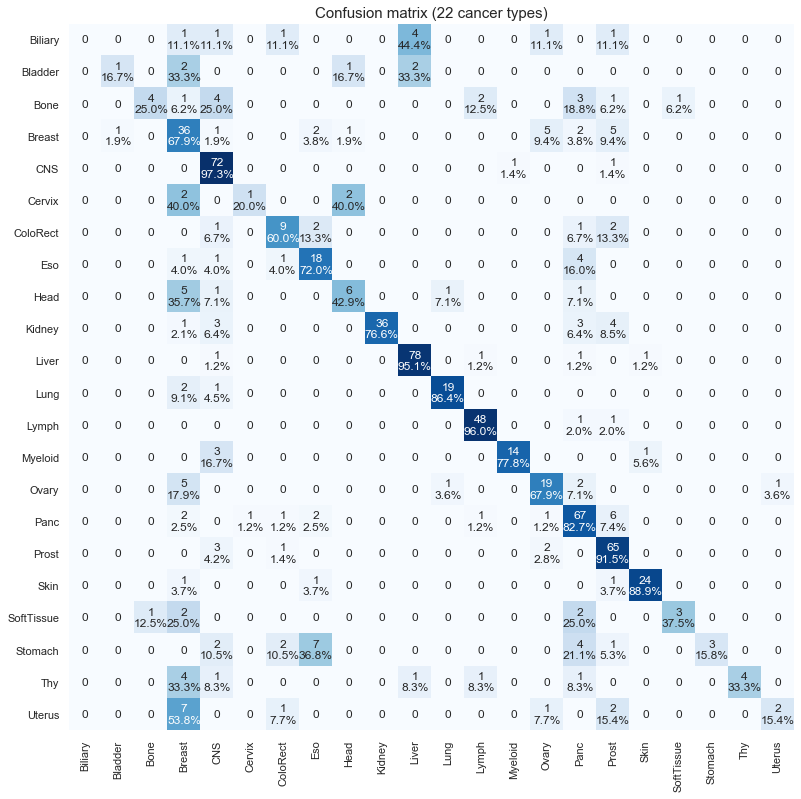

In [133]:
data_rf = construct_dataset(PCAWG_wgs_mut, subtypes=False, six_channels=False, sample_cutoff=10)

train_rf_x, test_rf_x, train_rf_y, test_rf_y, y_labels = prepare_rf_data(data_rf)
rf = random_forest(train_rf_x, test_rf_x, train_rf_y, test_rf_y, y_labels)

In [ ]:
data_rf = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=False, six_channels=False, sample_cutoff=10)

train_rf_x, test_rf_x, train_rf_y, test_rf_y, y_labels = prepare_rf_data(data_rf)
rf = random_forest(train_rf_x, test_rf_x, train_rf_y, test_rf_y, y_labels)

In [ ]:
data_rf = construct_dataset(nonPCAWG_wgs_mut, subtypes=False, six_channels=False, sample_cutoff=10)

train_rf_x, test_rf_x, train_rf_y, test_rf_y, y_labels = prepare_rf_data(data_rf)
rf = random_forest(train_rf_x, test_rf_x, train_rf_y, test_rf_y, y_labels)

Dropping: []
Dropping: ['Blood', 'Bone']
Accuracy:  0.7660869565217391
Mean Absolute Error: 2.353913043478261
Mean Squared Error: 30.501739130434782
Root Mean Squared Error: 5.522837959820547


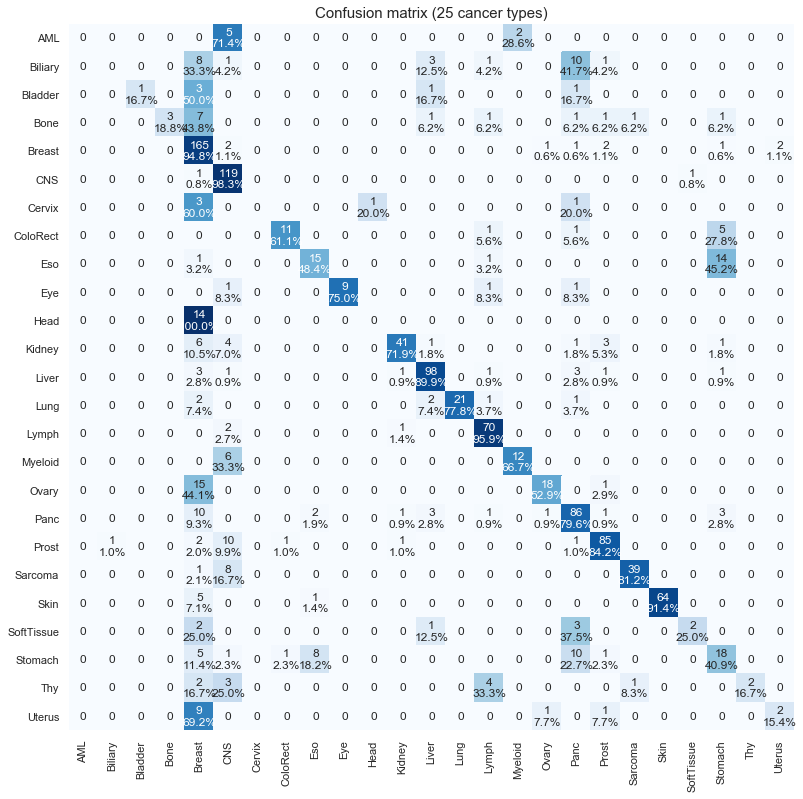

In [131]:
d1 = construct_dataset(PCAWG_wgs_mut, subtypes=False, six_channels=False, sample_cutoff=10)
d2 = construct_dataset(nonPCAWG_wgs_mut, subtypes=False, six_channels=False, sample_cutoff=10)
data_rf = pd.concat([d1, d2])
data_rf = data_rf.drop("ALL")
data_rf = data_rf.rename(index = {"Ewings": "Sarcoma"})
data_nn = data_nn.rename(index = {"AML": "Myeloid"})
data_rf = data_rf.sort_index()

train_rf_x, test_rf_x, train_rf_y, test_rf_y, y_labels = prepare_rf_data(data_rf)
rf = random_forest(train_rf_x, test_rf_x, train_rf_y, test_rf_y, y_labels)

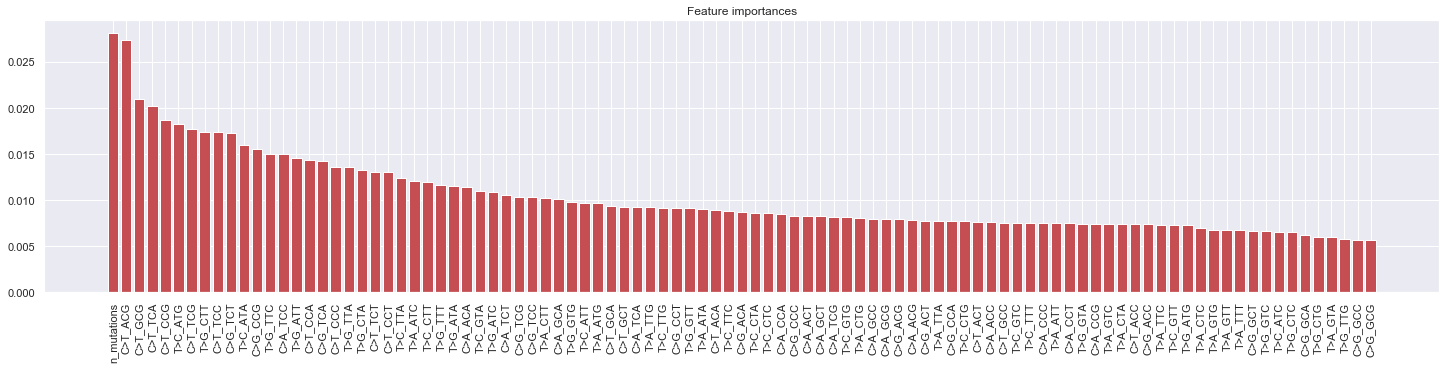

In [132]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(importances.shape[0]), importances[indices], color="r", align="center")
plt.xticks(range(importances.shape[0]), data_rf.columns[indices], rotation=90)
plt.show()

# Neural Network

In [140]:
import torch
import torchvision

class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_shape, output_shape, hidden_dim):
        super().__init__()
        self.input = torch.nn.Linear(in_features=input_shape, out_features=hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.hidden_1 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.hidden_2 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim)
        self.hidden_3 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.bn4 = torch.nn.BatchNorm1d(hidden_dim)
        self.output = torch.nn.Linear(in_features=hidden_dim, out_features=output_shape)

    def forward(self, x):
        l1 = torch.relu(self.bn1(self.input(x)))
        l2 = torch.relu(self.bn2(self.hidden_1(l1)))
        l3 = torch.relu(self.bn3(self.hidden_2(l2)))
        l4 = torch.relu(self.bn4(self.hidden_3(l3)))
        l5 = torch.relu(self.output(l4))
        return l5

def one_hot_labels(a):
    """
    input
        a: list; list of labels to transform into one-hot vectors
    return
        labels: numpy array; array of one-hot vectors
    """
    
    labels = np.zeros((len(a), len(set(a))))
    for i in range(len(a)):
        labels[i][a[i]] = 1
    return labels
    
def prepare_network_data(data, test_prop):
    """
    input
        data: DataFrame; data to split into training, validation and test data
        train_prop: float; the proportion of data entries to put into test data (the rest goes to train and validation data)
    return
        train_data: TensorDataset; train data
        validation_data: TensorDataset; validation data
        test_data: TensorDataset; test data
        y_labs: list; list of strings with label names
        n_classes: int; number of classes
    """
    
    x = np.array(data)
    y = np.array(data.index.values)

    # Convert labels to numbers
    to_int = {}
    y_labs = list(sorted(set(y)))
    for i in range(len(y_labs)):
        to_int[y_labs[i]] = i
    to_label = {x: y for y, x in to_int.items()}
    y = [to_int[x] for x in y]
    
    # Get number of classes
    n_classes = len(set(y))
    
    # Train, test and validation splits
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_prop, stratify=y)
    train_x, validation_x, train_y, validation_y = train_test_split(train_x, train_y, test_size=test_prop, 
                                                                    stratify=train_y)
    
    # Transform labels into one-hot vectors
    train_y = one_hot_labels(train_y)
    test_y = one_hot_labels(test_y)
    validation_y = one_hot_labels(validation_y)

    # Define datasets as TensorDataset
    train_data = torch.utils.data.TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
    validation_data = torch.utils.data.TensorDataset(torch.Tensor(validation_x), torch.Tensor(validation_y))
    test_data = torch.utils.data.TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))
    
    return train_data, validation_data, test_data, y_labs, n_classes
    
def train_network(net, train_data, validation_data, batch_size, epochs, learning_rate, device):
    """
    input
        net: torch.nn.model; neural network model
        train_data: TensorDataset; train data
        validation_data: TensorDataset; validation data
        batch_size: int; batch size
        epochs: int; number of epochs
        learning_rate: float; learning rate for optimizer
        device: torch.device; cpu or cuda device
    return
        net: torch.nn.model; trained neural network
        stats: DataFrame; performance statistics
    """
    
    print("Training: " + str(epochs) + " epochs, " + "learning rate " + str(learning_rate) + ", batch size " + str(batch_size))
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validation_data_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    objective = torch.nn.CrossEntropyLoss()
    
    stats = pd.DataFrame(columns=["Training_loss", "Training_accuracy", "Validation_loss", "Validation_accuracy"])
    
    for epoch in range(epochs+1):
        loss = 0
        n_correct = 0
        net.train()
        for batch, target in train_data_loader:
            batch = batch.to(device)
            target = target.to(device, dtype=torch.int64)
            optimizer.zero_grad()
            outputs = net(batch)
            train_loss = objective(outputs, torch.max(target, 1)[1])
            loss += train_loss.item()
            
            outs = outputs.cpu().data.numpy()
            targs = target.cpu().data.numpy()
            for i in range(outs.shape[0]):
                guess = np.where(outs[i] == max(outs[i]))[0][0]
                actual = np.where(targs[i] == 1)[0][0]
                if guess == actual:
                    n_correct += 1
        
            train_loss.backward()
            optimizer.step()

        loss = loss / len(train_data_loader)    
        acc = (n_correct / len(train_data))
            
        net.eval()
        val_loss = 0
        val_n_correct = 0
        with torch.no_grad():
            for batch, target in validation_data_loader:
                batch = batch.to(device)
                target = target.to(device, dtype=torch.int64)
                outputs = net(batch)
                val_loss += objective(outputs, torch.max(target, 1)[1]).item()
                outs = outputs.cpu().data.numpy()
                targs = target.cpu().data.numpy()
                for i in range(outs.shape[0]):
                    guess = np.where(outs[i] == max(outs[i]))[0][0]
                    actual = np.where(targs[i] == 1)[0][0]
                    if guess == actual:
                        val_n_correct += 1
        
        val_loss = val_loss / len(validation_data_loader)
        val_acc = val_n_correct / len(validation_data)
        
        stats = stats.append(pd.Series([loss, acc, val_loss, val_acc], index=stats.columns), ignore_index=True)
        
        if epoch % 100 == 0: 
            print("Epoch: " + str(epoch) + ", loss = " + str(loss) + ", accuracy = ", str(acc) + ", validation accuracy = ",
                 str(val_acc))

    return net, stats

def test_network(net, test_data, batch_size, n_classes, device):
    """
    input
        net: torch.nn.model; a trained neural network
        test_data: TensorDataset; test data
        batch_size: int; batch size
        n_classes: int; number of classes
        device: torch.device; cpu or cuda device
    return
        accuracy: float; testing accuracy (proportion of correctly classified samples)
        cmat: np.ndarray; confusion matrix
    """
    
    print("Testing: batch size " + str(batch_size) + ", " + str(n_classes) + " classes")
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    n_correct = 0
    cmat = np.zeros((n_classes, n_classes))
    with torch.no_grad():
        for batch, target in test_data_loader:
            batch = batch.to(device)
            target = target.to(device, dtype=torch.int64)
            outputs = net(batch)
            outs = outputs.cpu().data.numpy()
            targs = target.cpu().data.numpy()
            for i in range(outs.shape[0]):
                guess = np.where(outs[i] == max(outs[i]))[0][0]
                actual = np.where(targs[i] == 1)[0][0]
                cmat[actual, guess] += 1
                if guess == actual:
                    n_correct += 1
    
    accuracy = n_correct/len(test_data)
    
    return accuracy, np.ndarray.astype(cmat, "int")

def plot_nn_statistics(stats):
    """
    input
        stats: DataFrame; statistics from neural network training (train_network output)
    return
        n/a
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Neural network performance')
    x = range(len(stats))
    axs[0, 0].plot(x, stats["Training_loss"])
    axs[0, 0].set_title("Training loss")
    axs[0, 1].plot(x, stats["Training_accuracy"])
    axs[0, 1].set_title("Training accuracy")
    axs[1, 0].plot(x, stats["Validation_loss"])
    axs[1, 0].set_title("Validation loss")
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 1].plot(x, stats["Validation_accuracy"])
    axs[1, 1].set_title("Validation accuracy")
    axs[1, 1].set_xlabel("Epochs")

    plt.xlabel("Epochs")
    plt.show()

# Neural network with PCAWG + non-PCAWG data

Below a 6 layer neural network (4 hidden layers) is trained on combined PCAWG and Other mutation count data without signatures.

In [148]:
d1 = construct_dataset(PCAWG_wgs_mut, subtypes=False, six_channels=False, sample_cutoff=10)
d2 = construct_dataset(nonPCAWG_wgs_mut, subtypes=False, six_channels=False, sample_cutoff=10)
data_nn = pd.concat([d1, d2])
data_nn = data_nn.drop("ALL")
data_nn = data_nn.rename(index = {"Ewings": "Sarcoma"})
data_nn = data_nn.rename(index = {"AML": "Myeloid"})
data_nn = data_nn.sort_index()

batch_size = 128
hidden_layer_size = 2048
learning_rate = 0.015
epochs = 500
test_prop = 0.25
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_data, validation_data, test_data, labels, n_classes = prepare_network_data(data=data_nn, test_prop=test_prop)
net = NeuralNetwork(input_shape=data_nn.shape[1], output_shape=len(set(data_nn.index.values)), hidden_dim=hidden_layer_size)
net.to(device)
net, stats = train_network(net=net, train_data=train_data, validation_data=validation_data, batch_size=batch_size, epochs=epochs, 
                           learning_rate=learning_rate, device=device)

Dropping: []
Dropping: ['Blood', 'Bone']
Training: 500 epochs, learning rate 0.015, batch size 128
Epoch: 0, loss = 2.1849070390065513, accuracy =  0.436412833397758, validation accuracy =  0.15179606025492468
Epoch: 100, loss = 0.04619563317724636, accuracy =  0.989563200618477, validation accuracy =  0.8192352259559675
Epoch: 200, loss = 0.008123445457645826, accuracy =  0.9992269037495168, validation accuracy =  0.8215527230590962
Epoch: 300, loss = 0.005707551464660182, accuracy =  0.9984538074990337, validation accuracy =  0.8342989571263036
Epoch: 400, loss = 0.002968867253955631, accuracy =  0.9984538074990337, validation accuracy =  0.828505214368482
Epoch: 500, loss = 0.007173302483611873, accuracy =  0.998067259373792, validation accuracy =  0.8238702201622248


The validation results display acceptable classification accuracy - ~83 percent. Training accuracy approaches 1 with minimal loss. That represents a large improvement from random forest.

Testing: batch size 128, 24 classes
Testing accuracy:  0.828695652173913


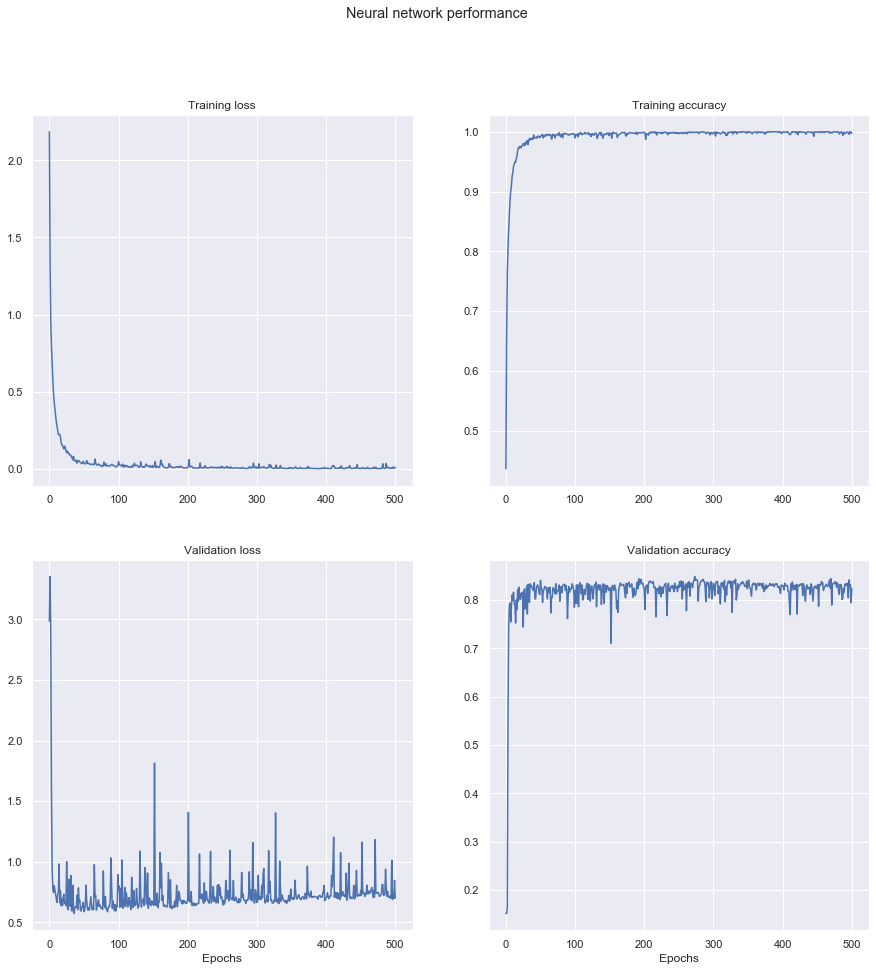

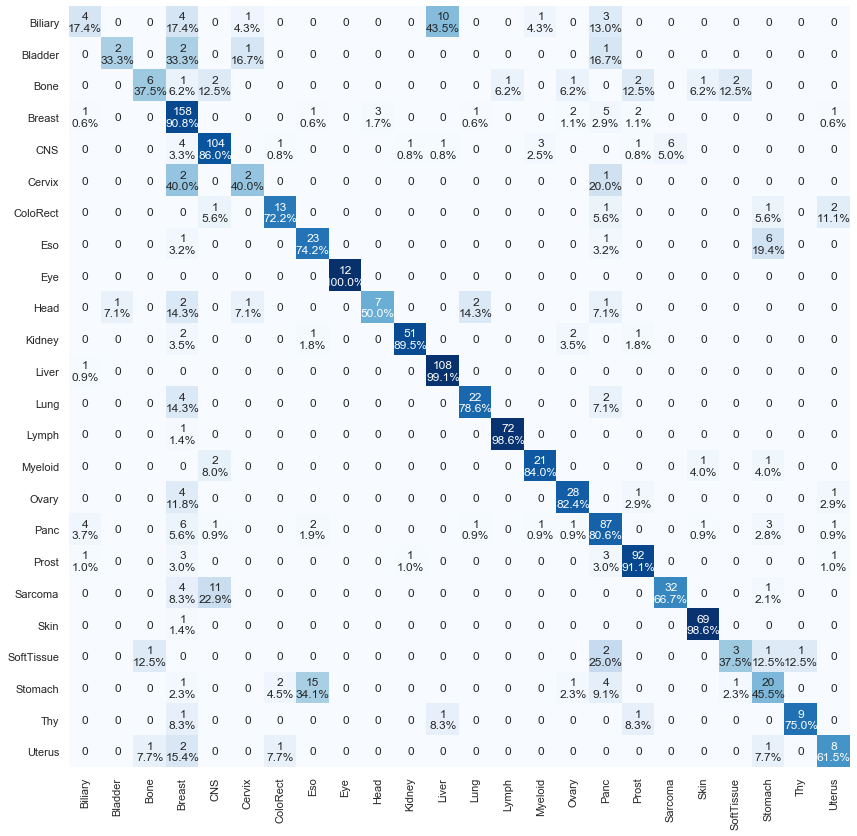

In [149]:
accuracy, cmat = test_network(net, test_data, 128, n_classes, device=device)
print("Testing accuracy: ", accuracy)
plot_nn_statistics(stats)
confusion_matrix_plot(cmat, labels, "Neural network confusion matrix (" + str(n_classes) + " cancer types)")

The confusion matrix suggests that cancer types of similar organs - for example, bile duct cancer (Biliary) is highly similar to liver cancer. Similarly, stomach cancer is misclassified as esophageal (Eso).

# Neural network with PCAWG-only data

Another neural network implementation with slightly different parameters is shown below, used with PCAWG-only data.

In [155]:
data_nn = construct_dataset(PCAWG_wgs_mut, subtypes=False, six_channels=False, sample_cutoff=50)

batch_size = 128
hidden_layer_size = 1024
learning_rate = 0.025
epochs = 500
test_prop = 0.25
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_data, validation_data, test_data, labels, n_classes = prepare_network_data(data=data_nn, test_prop=test_prop)
net = NeuralNetwork(input_shape=data_nn.shape[1], output_shape=len(set(data_nn.index.values)), hidden_dim=hidden_layer_size)
net.to(device)
net, stats = train_network(net=net, train_data=train_data, validation_data=validation_data, batch_size=batch_size, epochs=epochs, 
                           learning_rate=learning_rate, device=device)

Dropping: []
Training: 500 epochs, learning rate 0.025, batch size 128
Epoch: 0, loss = 2.4511553782683153, accuracy =  0.3352527191298784, validation accuracy =  0.11494252873563218
Epoch: 100, loss = 0.0276685614998524, accuracy =  0.9968010236724248, validation accuracy =  0.7950191570881227
Epoch: 200, loss = 0.01730057769096815, accuracy =  0.9955214331413947, validation accuracy =  0.7931034482758621
Epoch: 300, loss = 0.0032491044571193364, accuracy =  1.0, validation accuracy =  0.8180076628352491
Epoch: 400, loss = 0.0015093284444167064, accuracy =  1.0, validation accuracy =  0.8199233716475096
Epoch: 500, loss = 0.0016634943536840952, accuracy =  1.0, validation accuracy =  0.8218390804597702


Testing: batch size 128, 22 classes
Testing accuracy:  0.7913669064748201


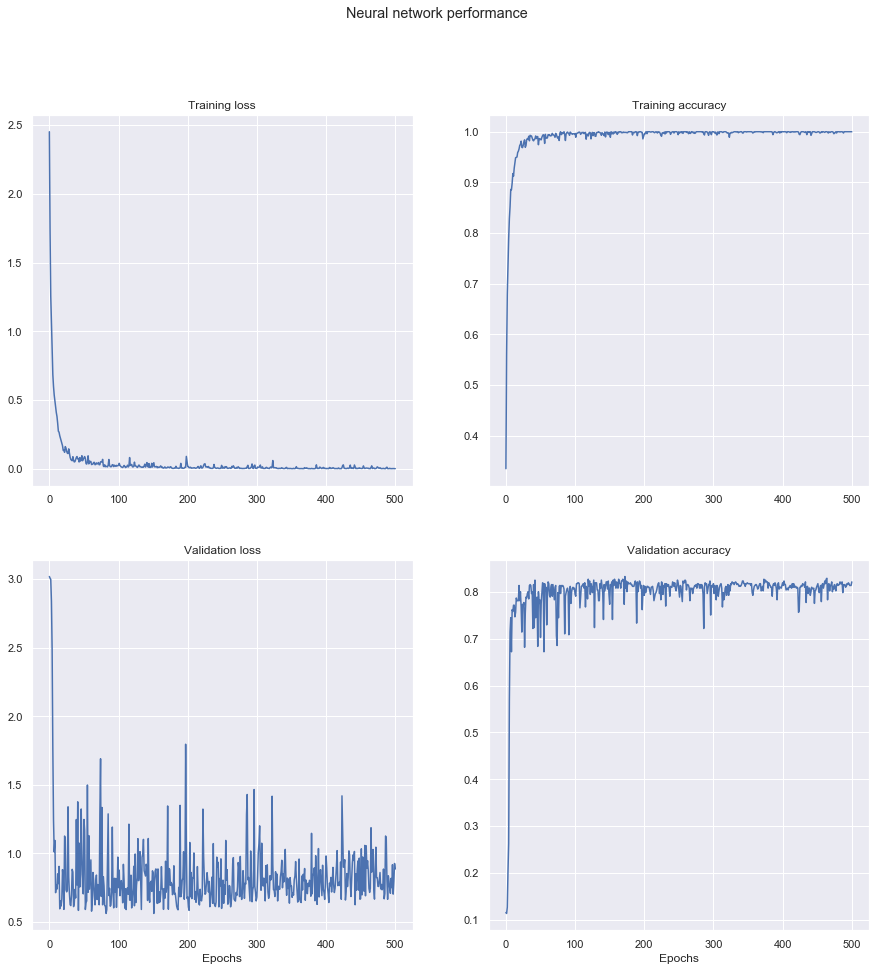

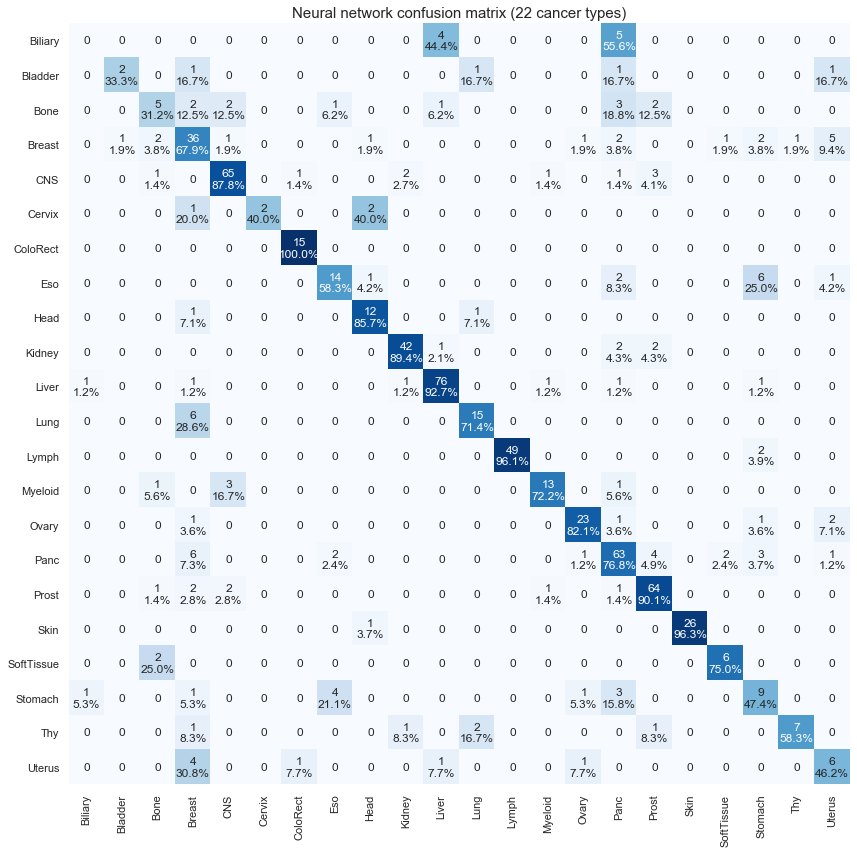

In [157]:
accuracy, cmat = test_network(net, test_data, 128, n_classes, device=device)
print("Testing accuracy: ", accuracy)
plot_nn_statistics(stats)
confusion_matrix_plot(cmat, labels, "Neural network confusion matrix (" + str(n_classes) + " cancer types)")

# Support Vector Machine

In [169]:
def grid_search(X_train, y_train, kernel='rbf', return_val_acc=False):
    """
    Grid search to tune C for SVM
    
    input
        X_train: array-like, [n_samples, n_features]; input data for training
        y_train: array-like, [n_samples]; output data for training
        kernel: string, optional (default='rbf').
            Kernel to use in SVM; it must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable
    
    return
        best_C_gamma: best pair of C and gamma through grid search
    """
    param_list = [0.001, 0.01, 0.1, 1, 10, 100]
    best_score = 0
    
    if kernel=='linear':
        best_gamma = 'N/A'
        for C in param_list:
            model = LinearSVC(C=C)
            score = np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1))
            if score > best_score:
                best_score = score
                best_C = C
    
    else:
        for C in param_list:
            for gamma in param_list:
                model = SVC(C=C, gamma=gamma, kernel=kernel)
                score = np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1))
                if score > best_score:
                    best_score = score
                    best_C = C
                    best_gamma = gamma
    print("Grid Search Result")
    print("Validation Accuracy:", best_score)
    print("Best C:", best_C)
    print("Best gamma:", best_gamma)
    best_C_gamma = [best_C, best_gamma]
    
    if return_val_acc:
        return best_C_gamma, best_score
    else:
        return best_C_gamma

def SVM(X_train, X_test, y_train, y_test, C, gamma, kernel='rbf', return_y_pred=False, return_test_acc=False):
    """
    Train and test SVM algorithm
    
    input
        X_train: array-like, [n_samples, n_features]; input data for training
        X_test: array-like, [n_samples, n_features]; input data for testing
        y_train: array-like, [n_samples]; output data for training
        y_test: array-like, [n_samples]; output data for testing
        C: int; parameter C for SVM
        gamma: int; parameter gamma for SVM
        kernel: string, optional (default='rbf')
            Kernel to use in SVM; it must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable 
    
    return
        model: trained SVM model
    """
    if kernel=='linear':
        model = LinearSVC(C=C)
    
    else:
        model = SVC(C=C, gamma=gamma, kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_pred, y_test)
    
    print("Test Accuracy:", score)
    
    if return_y_pred:
        if return_test_acc:
            return model, y_pred, score
        else:
            return model, y_pred
    
    else:
        if return_test_acc:
            return model, score
        else:
            return model

Here we try SVM with both linear and rbf kernels for PCAWG mutation profile data with non-subtype labeling and 96 channels below:

kernel: linear
Grid Search Result
Validation Accuracy: 0.7557198891647774
Best C: 100
Best gamma: N/A
Test Accuracy: 0.7977099236641222


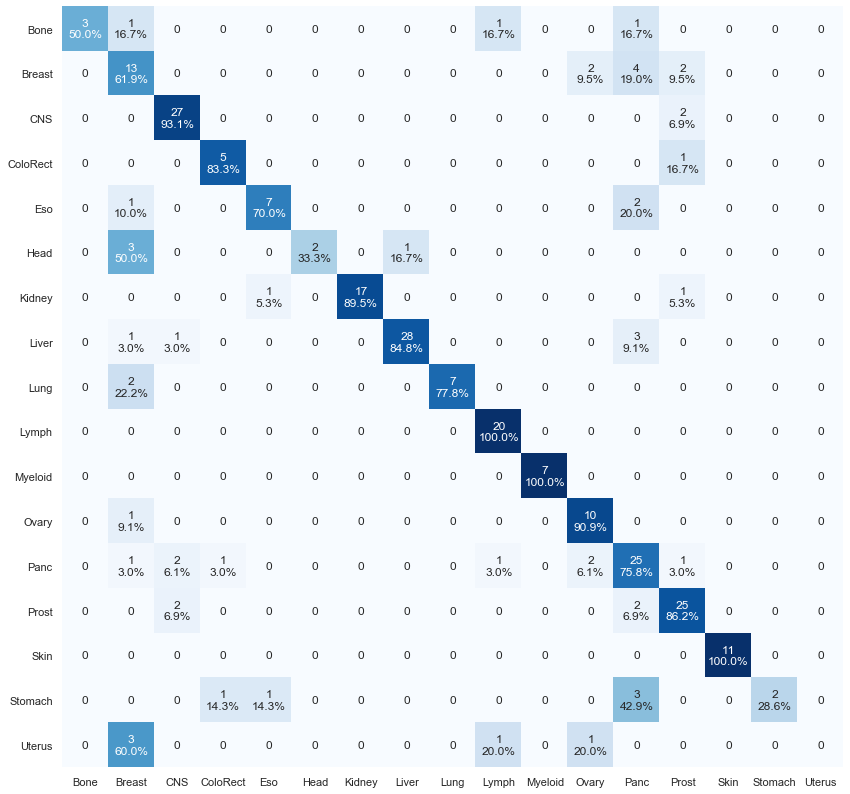


kernel: rbf
Grid Search Result
Validation Accuracy: 0.8324885746158552
Best C: 10
Best gamma: 100
Test Accuracy: 0.8396946564885496


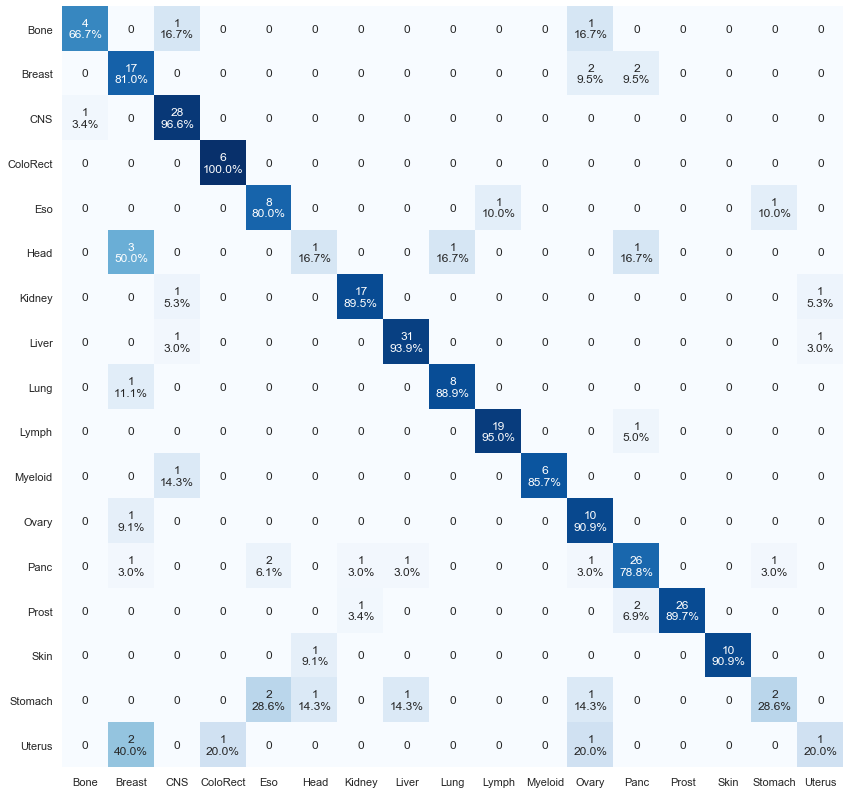

In [170]:
npr.seed(42)
kernels = ['linear', 'rbf']
data = datasets["PCAWG"]
for k in kernels:
    print("kernel:", k)
    X_train, X_test, y_train, y_test = train_test_split(data, data.index.values, test_size=0.1, stratify=data.index.values)
    # supress warnings when optimization doesn't converge, which often happens when kernel is linear
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        best_C_gamma = grid_search(X_train, y_train, kernel=k)
        _, y_pred = SVM(X_train, X_test, y_train, y_test, best_C_gamma[0], best_C_gamma[1], kernel=k, return_y_pred=True)
        cmat = metrics.confusion_matrix(y_test, y_pred)
        label = np.unique(np.concatenate((y_test, y_pred)))
        confusion_matrix_plot(cmat, label)
        
    print("")

We intuitively guessed rbf kernel worked better than linear kernel, and it is consistent with the result above.  
As we have many different datasets to try algorithms on, we work only rbf kernel from now on.  
Firstly, we try to run the algorithm with rbf kernel on three datasets: PCAWG, other, and WGS (PCAWG and other combined).

PCAWG
Grid Search Result
Validation Accuracy: 0.8375778185613012
Best C: 10
Best gamma: 100
Test Accuracy: 0.851145038167939


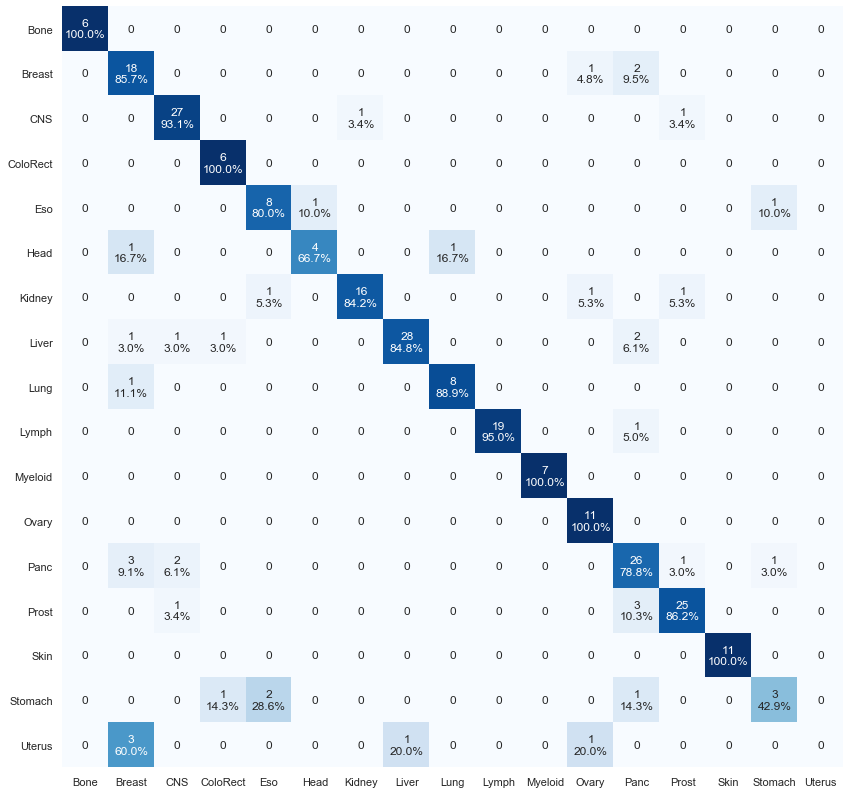


Other
Grid Search Result
Validation Accuracy: 0.7835616438356164
Best C: 100
Best gamma: 100
Test Accuracy: 0.7791411042944786


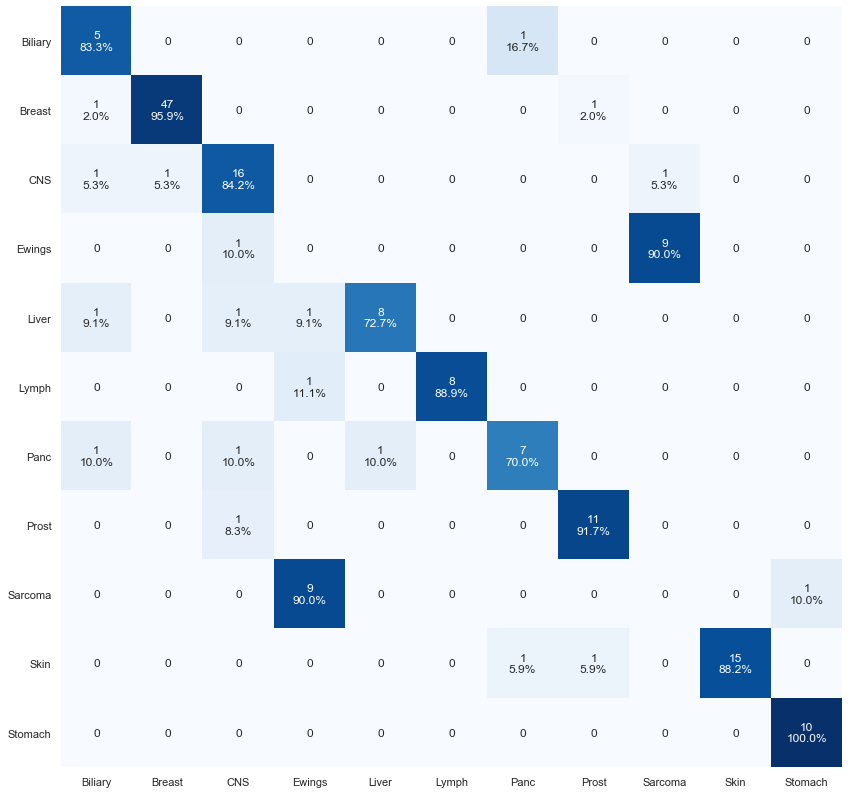


WGS
Grid Search Result
Validation Accuracy: 0.8095867099421545
Best C: 10
Best gamma: 100
Test Accuracy: 0.8117647058823529


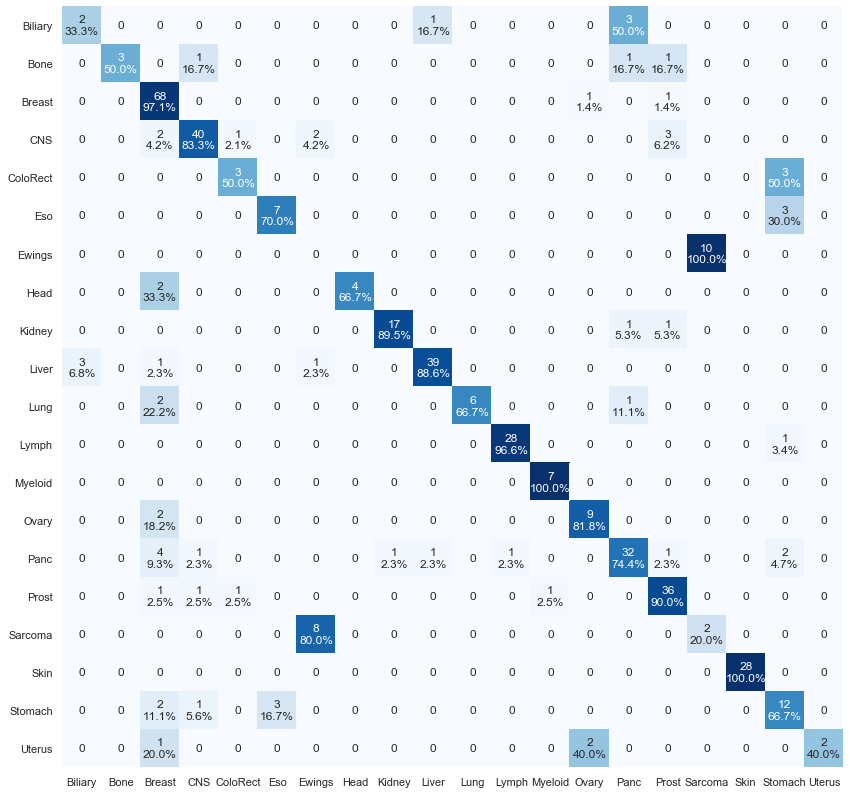

In [171]:
npr.seed(42)
dataset_names = ['PCAWG', 'Other', 'WGS']
cmats = {}
labels = {}
val_accs = {}
test_accs = {}
for name in dataset_names:
    data = datasets[name]
    print(name)
    X_train, X_test, y_train, y_test = train_test_split(data, data.index.values, test_size=0.1, stratify=data.index.values)
    best_C_gamma, val_accs[name] = grid_search(X_train, y_train, kernel='rbf', return_val_acc=True)
    _, y_pred, test_accs[name] = SVM(X_train, X_test, y_train, y_test, best_C_gamma[0], best_C_gamma[1], kernel='rbf',
                                     return_y_pred=True, return_test_acc=True)
    cmats[name] = metrics.confusion_matrix(y_test, y_pred)
    labels[name] = np.unique(np.concatenate((y_test, y_pred)))
    confusion_matrix_plot(cmats[name], labels[name])
        
    print("")

Comparing results from PCAWG and other, we can tell that PCAWG is a better dataset (for our classification problem) in general, presumably because other dataset has more noises than PCAWG dataset.
So the question is whether adding other dataset to PCAWG dataset, we can improve classification.
Since PCAWG and other has some unshared labels, we compare the classification accuracies for the shared labels for this question.
It seems hard to decide if having additional data from other dataset would improve classification since difference is highly label dependent, although the overall accuracy is better with PCAWG dataset than with WGS dataset.
For further analysis, we focus on both PCAWG and WGS dataset. 
Next, we consider adding signature activity data and see how it affects classification quality.

In [172]:
npr.seed(42)
dataset_names = ['PCAWG_with_act', 'WGS_with_act']
for name in dataset_names:
    data = datasets[name]
    print(name)
    X_train, X_test, y_train, y_test = train_test_split(data, data.index.values, test_size=0.1, stratify=data.index.values)
    best_C_gamma, val_accs[name] = grid_search(X_train, y_train, kernel='rbf', return_val_acc=True)
    _, y_pred, test_accs[name] = SVM(X_train, X_test, y_train, y_test, best_C_gamma[0], best_C_gamma[1], kernel='rbf',
                                     return_y_pred=True, return_test_acc=True)
    cmats[name] = metrics.confusion_matrix(y_test, y_pred)
    labels[name] = np.unique(np.concatenate((y_test, y_pred)))
    print("")

PCAWG_with_act
Grid Search Result
Validation Accuracy: 0.8079006081543056
Best C: 100
Best gamma: 1
Test Accuracy: 0.8282442748091603

WGS_with_act
Grid Search Result
Validation Accuracy: 0.7805105912868054
Best C: 100
Best gamma: 10
Test Accuracy: 0.7929411764705883



PCAWG
Validation Accuracy: 0.8375778185613012
Test Accuracy: 0.851145038167939


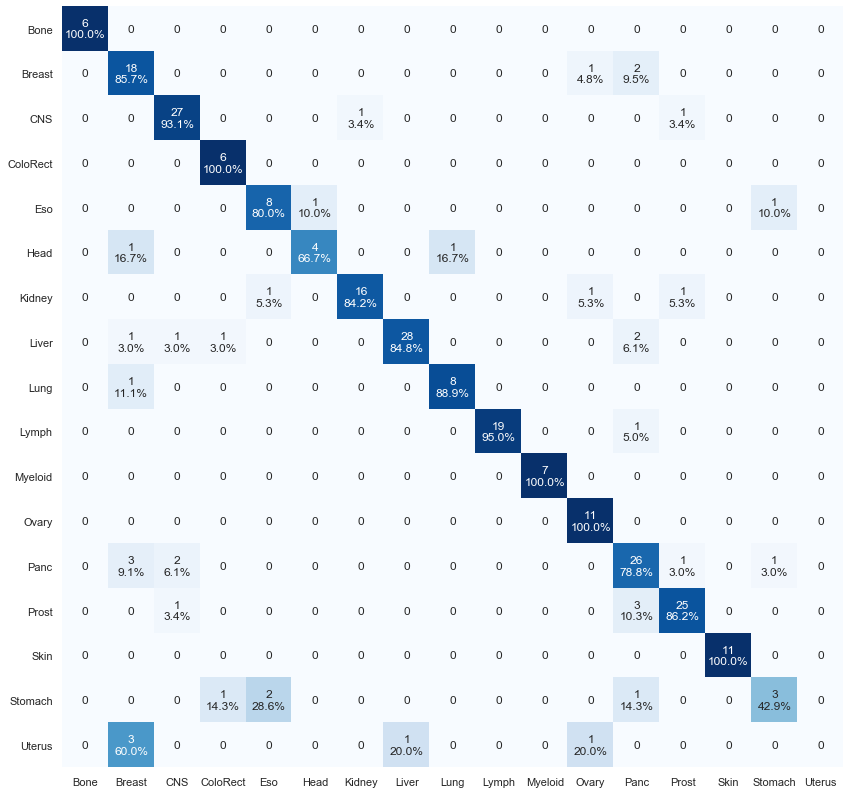

PCAWG_with_act
Validation Accuracy: 0.8079006081543056
Test Accuracy: 0.8282442748091603


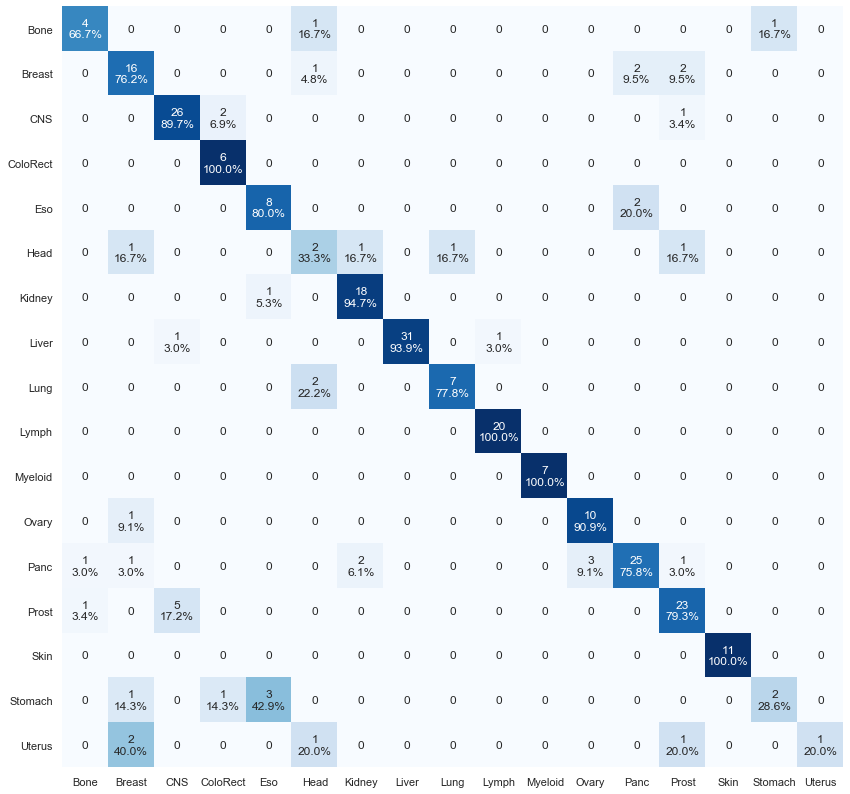

WGS
Validation Accuracy: 0.8095867099421545
Test Accuracy: 0.8117647058823529


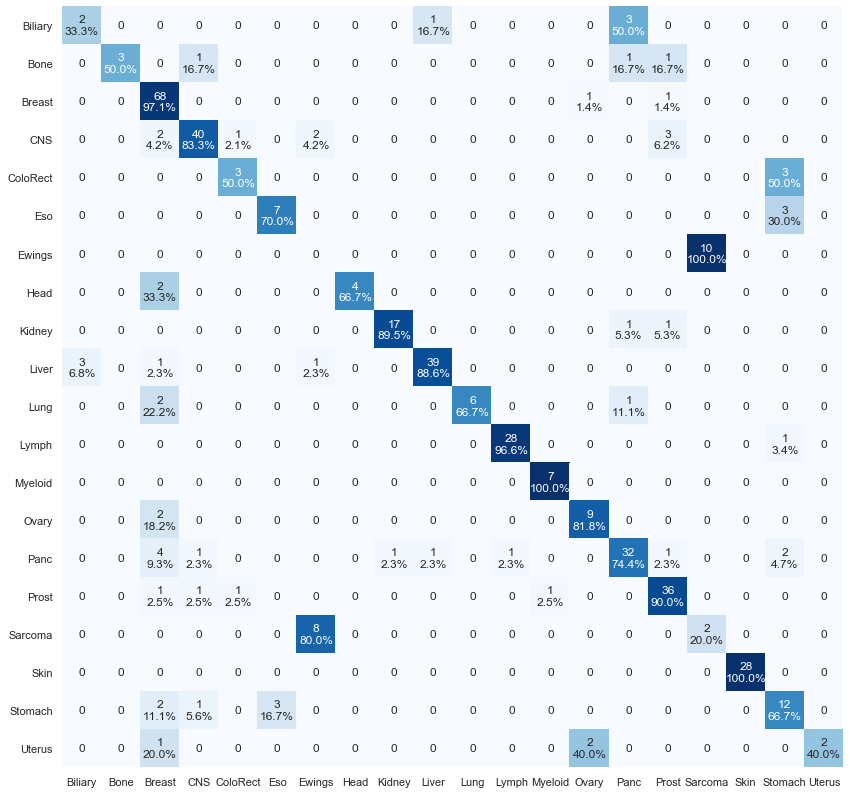

WGS_with_act
Validation Accuracy: 0.7805105912868054
Test Accuracy: 0.7929411764705883


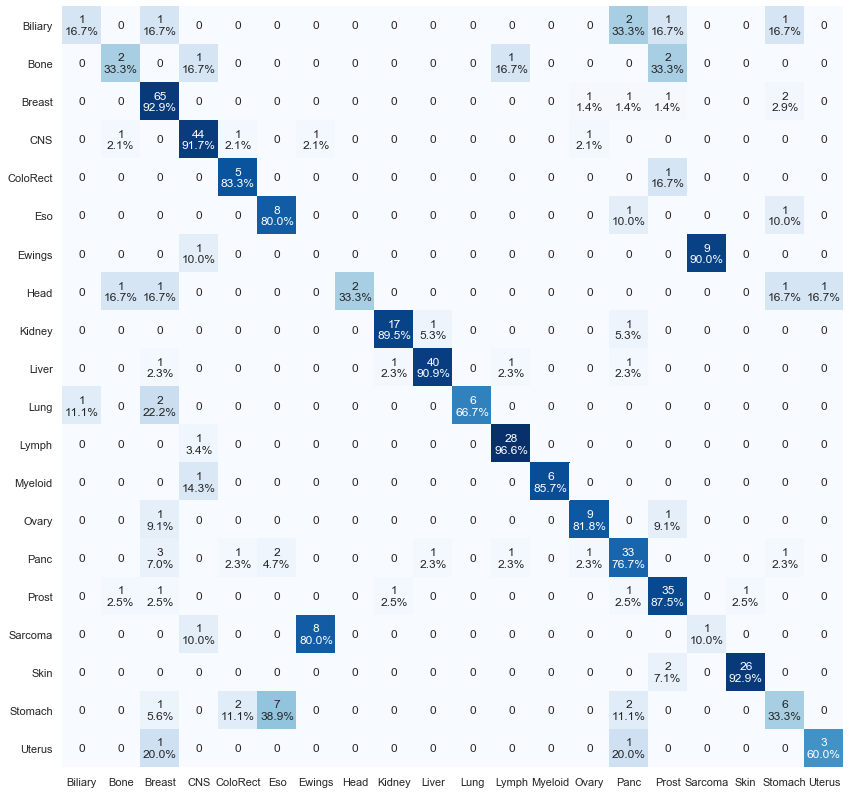

In [173]:
dataset_names = ['PCAWG', 'PCAWG_with_act', 'WGS', 'WGS_with_act']
for name in dataset_names:
    print(name)
    print("Validation Accuracy:", val_accs[name])
    print("Test Accuracy:", test_accs[name])
    confusion_matrix_plot(cmats[name], labels[name])

Interestingly, with both dataset PCAWG and WGS, adding signature activity data mostly deproved classifcation quality.
For further analysis from now on, we do not use signature activity data together with mutational profile data.
This could be due to high complexity of data and overfitting issue. 
Now, we look at whether using subtype label makes it harder to classify data than using non-subtype label.

In [174]:
npr.seed(42)
dataset_names = ['PCAWG_sub', 'WGS_sub']
for name in dataset_names:
    data = datasets[name]
    print(name)
    X_train, X_test, y_train, y_test = train_test_split(data, data.index.values, test_size=0.1, stratify=data.index.values)
    best_C_gamma, val_accs[name] = grid_search(X_train, y_train, kernel='rbf', return_val_acc=True)
    _, y_pred, test_accs[name] = SVM(X_train, X_test, y_train, y_test, best_C_gamma[0], best_C_gamma[1], kernel='rbf',
                                     return_y_pred=True, return_test_acc=True)
    cmats[name] = metrics.confusion_matrix(y_test, y_pred)
    labels[name] = np.unique(np.concatenate((y_test, y_pred)))
    print("")

PCAWG_sub
Grid Search Result
Validation Accuracy: 0.8300000000000001
Best C: 10
Best gamma: 100
Test Accuracy: 0.8888888888888888

WGS_sub
Grid Search Result
Validation Accuracy: 0.7336850433078773
Best C: 100
Best gamma: 100
Test Accuracy: 0.7422680412371134



PCAWG
Validation Accuracy: 0.8375778185613012
Test Accuracy: 0.851145038167939


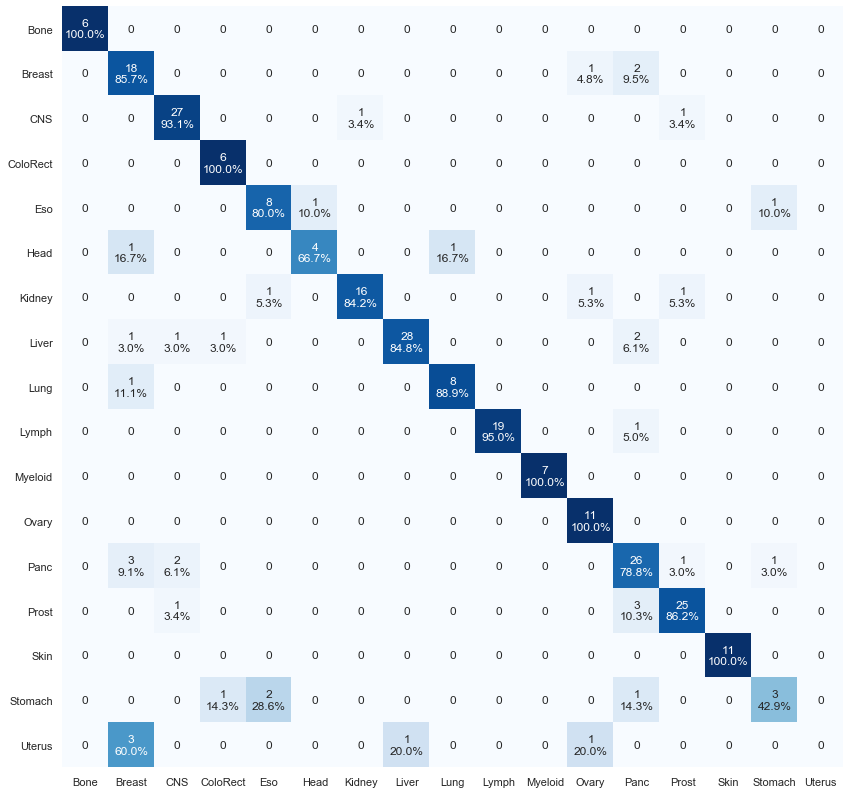

PCAWG_sub
Validation Accuracy: 0.8300000000000001
Test Accuracy: 0.8888888888888888


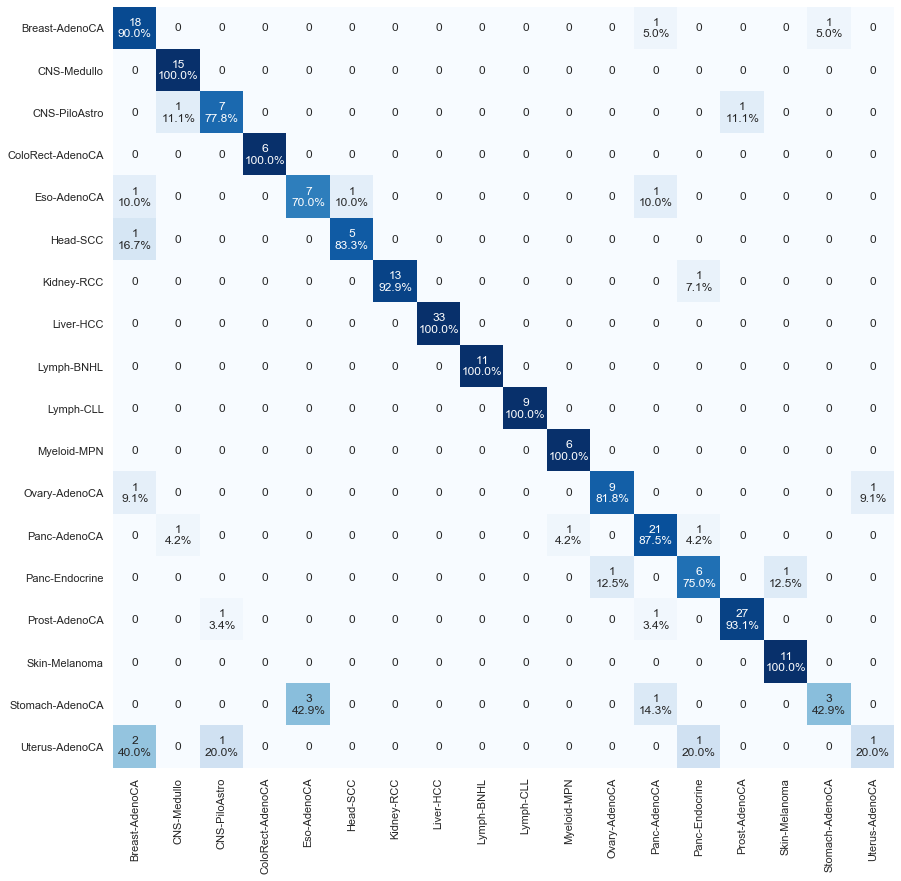

WGS
Validation Accuracy: 0.8095867099421545
Test Accuracy: 0.8117647058823529


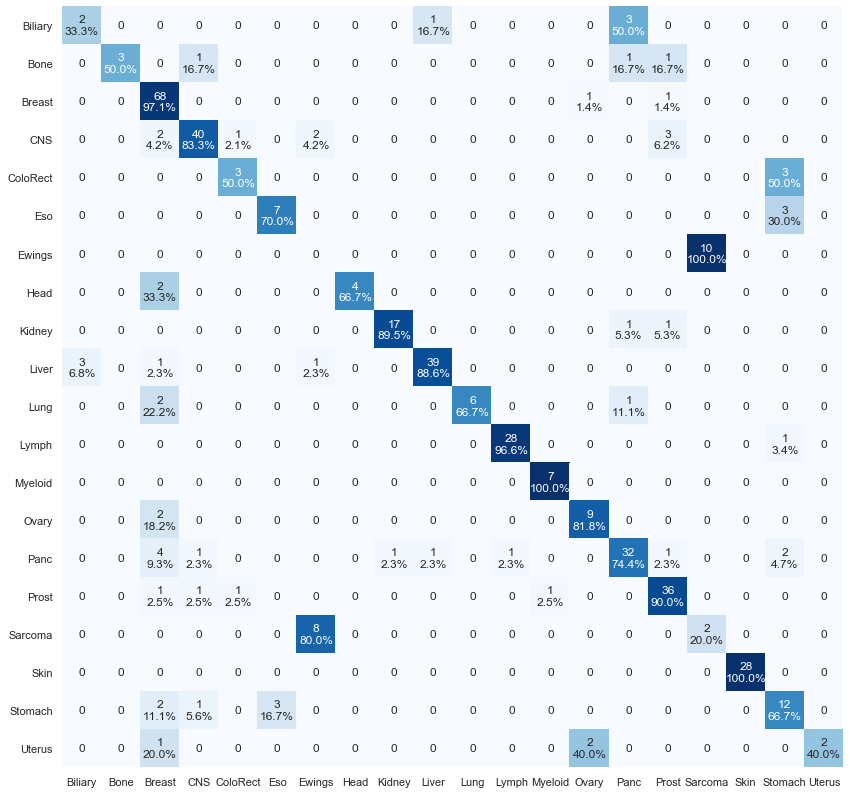

WGS_sub
Validation Accuracy: 0.7336850433078773
Test Accuracy: 0.7422680412371134


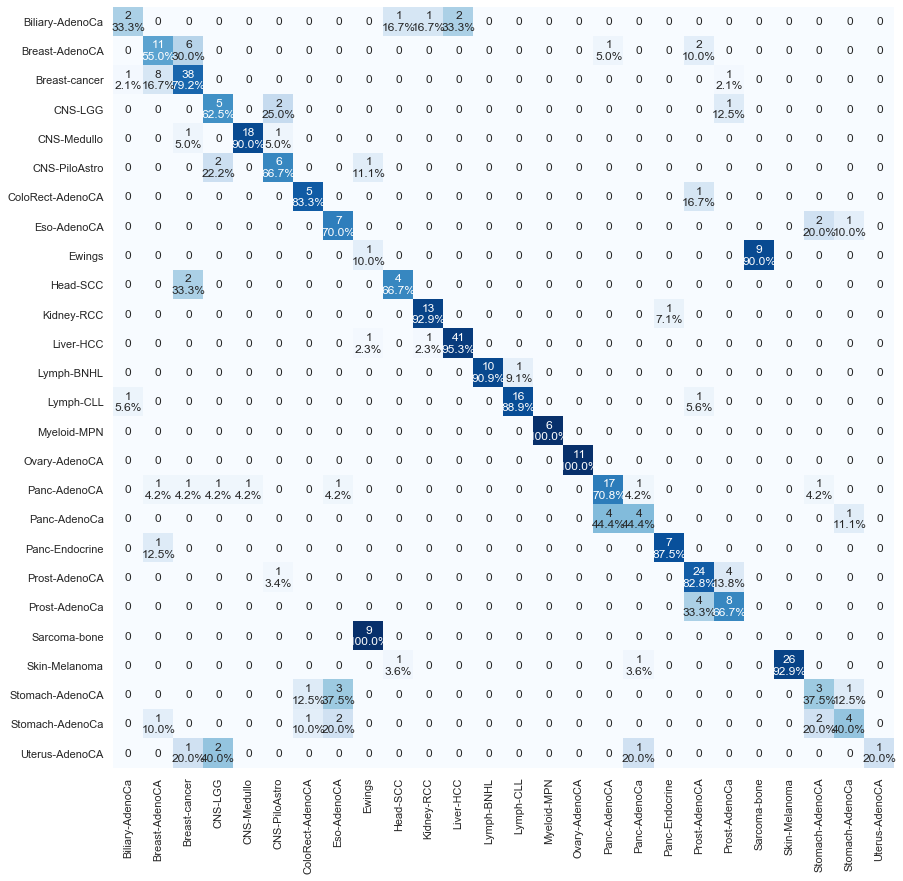

In [175]:
dataset_names = ['PCAWG', 'PCAWG_sub', 'WGS', 'WGS_sub']
for name in dataset_names:
    print(name)
    print("Validation Accuracy:", val_accs[name])
    print("Test Accuracy:", test_accs[name])
    confusion_matrix_plot(cmats[name], labels[name])

As illustrated above, subtype labels are harder to classify than non-subtype labels.
From now on, we use subtype label since it would be more informative and harder to work on. 
Next, we check whether using 6 channels instead of 96 channels would improve classification.

In [177]:
npr.seed(42)
dataset_names = ['PCAWG_sub_sixchan', 'WGS_sub_sixchan']
for name in dataset_names:
    data = datasets[name]
    print(name)
    X_train, X_test, y_train, y_test = train_test_split(data, data.index.values, test_size=0.1, stratify=data.index.values)
    best_C_gamma, val_accs[name] = grid_search(X_train, y_train, kernel='rbf', return_val_acc=True)
    _, y_pred, test_accs[name] = SVM(X_train, X_test, y_train, y_test, best_C_gamma[0], best_C_gamma[1], kernel='rbf',
                                     return_y_pred=True, return_test_acc=True)
    cmats[name] = metrics.confusion_matrix(y_test, y_pred)
    labels[name] = np.unique(np.concatenate((y_test, y_pred)))
    print("")

PCAWG_sub_sixchan
Grid Search Result
Validation Accuracy: 0.6080952380952381
Best C: 100
Best gamma: 10
Test Accuracy: 0.6581196581196581

WGS_sub_sixchan
Grid Search Result
Validation Accuracy: 0.5071596345167677
Best C: 10
Best gamma: 100
Test Accuracy: 0.48711340206185566



PCAWG_sub
Validation Accuracy: 0.8300000000000001
Test Accuracy: 0.8888888888888888


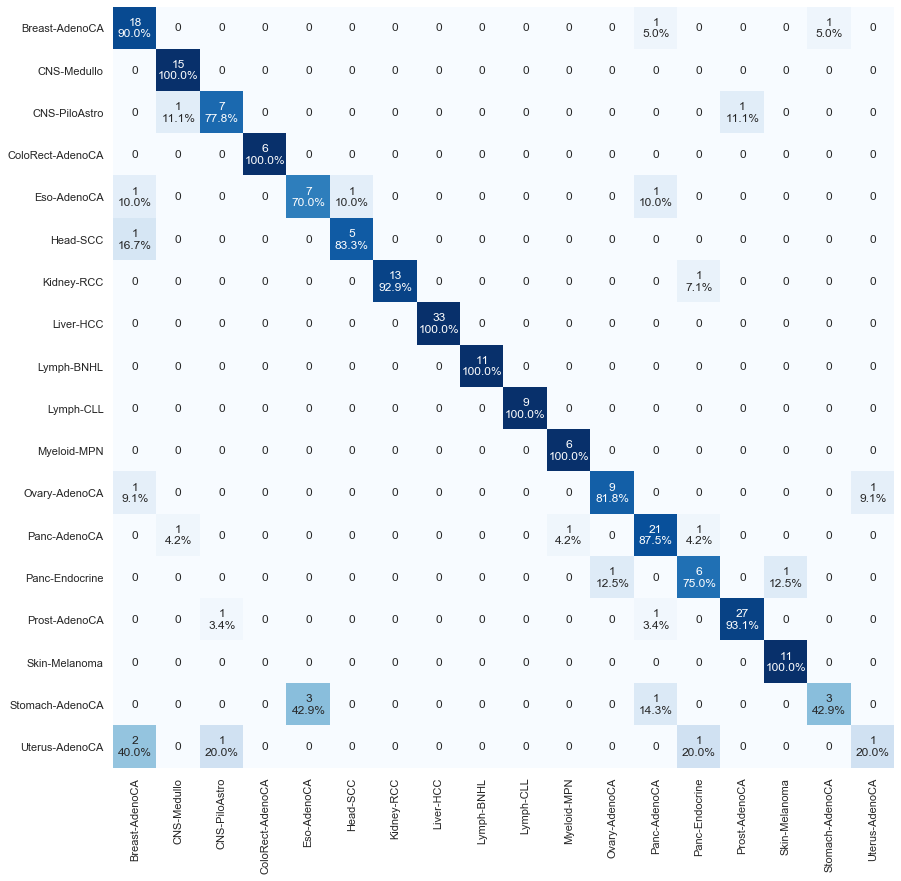

PCAWG_sub_sixchan
Validation Accuracy: 0.6080952380952381
Test Accuracy: 0.6581196581196581


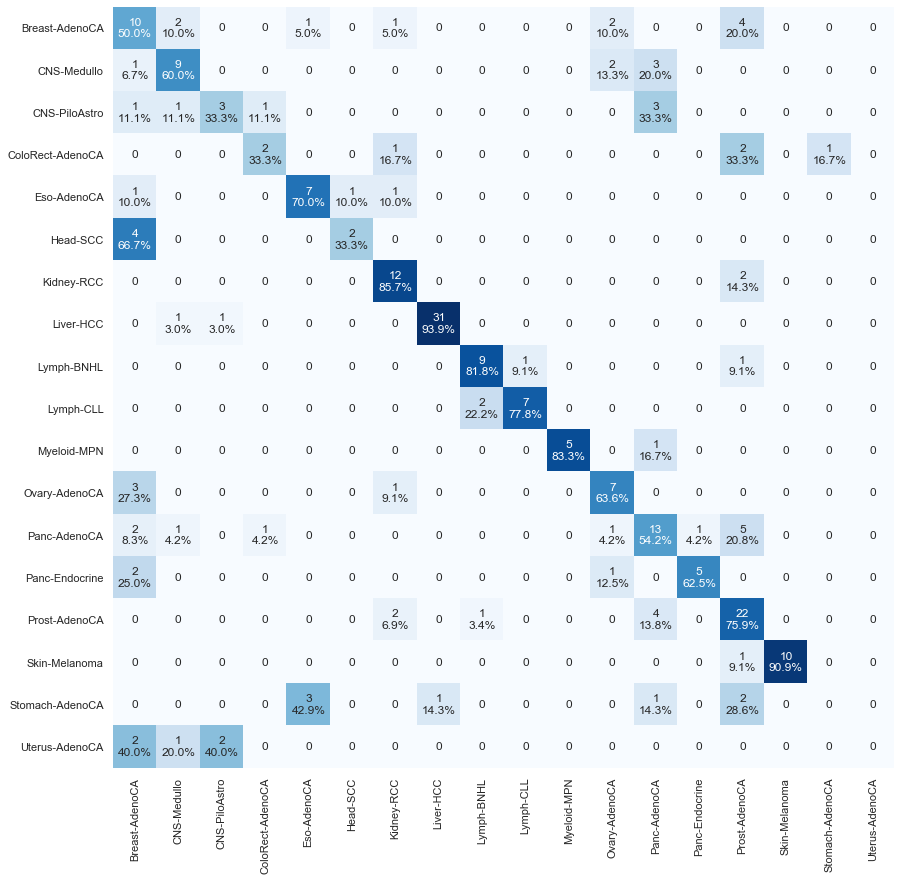

WGS_sub
Validation Accuracy: 0.7336850433078773
Test Accuracy: 0.7422680412371134


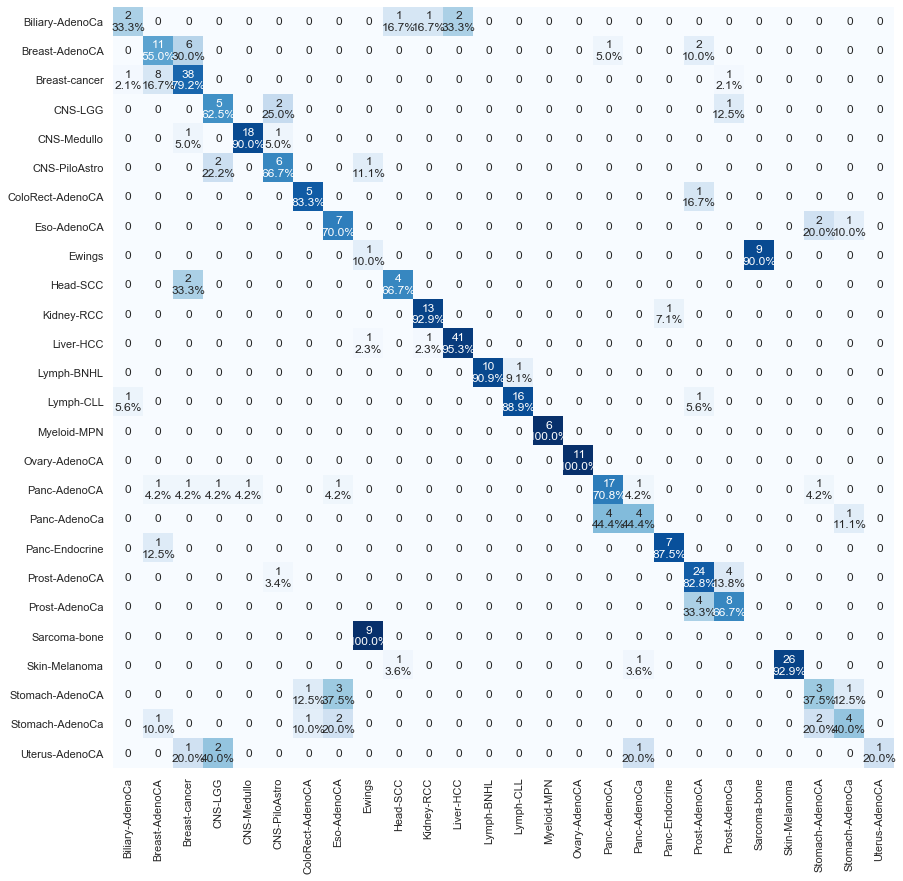

WGS_sub_sixchan
Validation Accuracy: 0.5071596345167677
Test Accuracy: 0.48711340206185566


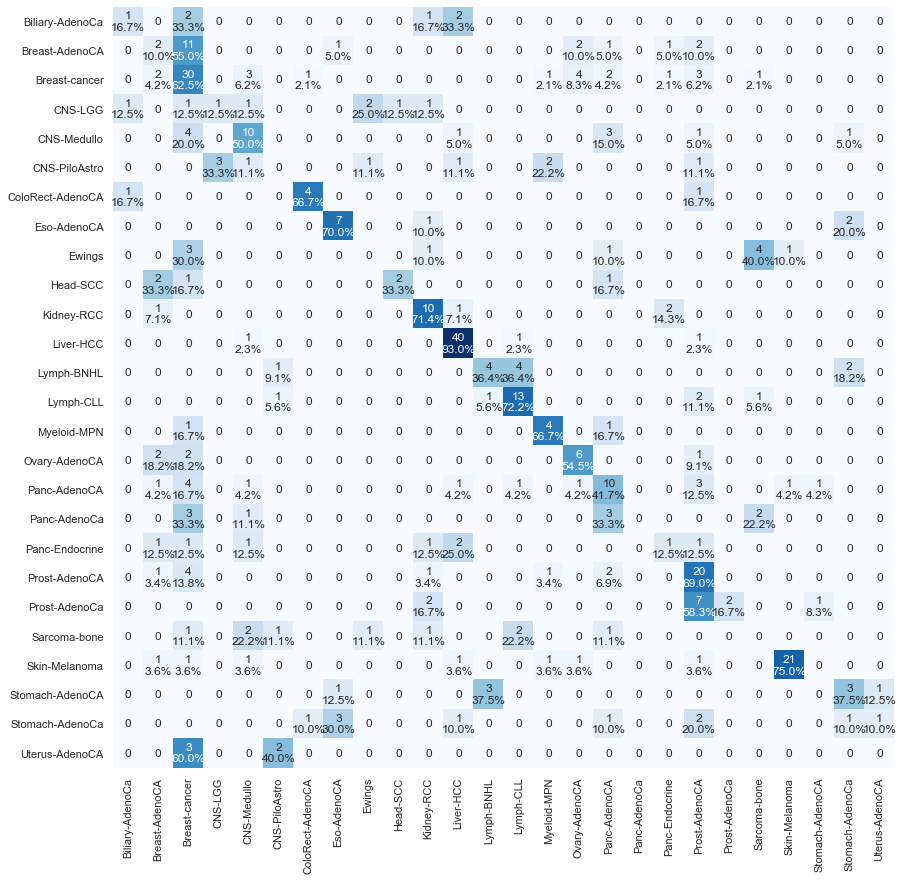

In [178]:
dataset_names = ['PCAWG_sub', 'PCAWG_sub_sixchan', 'WGS_sub', 'WGS_sub_sixchan']
for name in dataset_names:
    print(name)
    print("Validation Accuracy:", val_accs[name])
    print("Test Accuracy:", test_accs[name])
    confusion_matrix_plot(cmats[name], labels[name])

From the results above, using six channels instead of 96 channels reduce info available vastly and classification quality suffers a lot from that.
From exploration so far, as for data from WGS, the best result can be obtained by using 96 channels without signature activity data.
However, using dimension reduction algorithm, result might improve on dataset with signature activity data. 
Now, we start working on WES.

# Jun

In [179]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import sklearn
import sklearn.manifold

In [181]:
class Dataset:
    def __init__(self, mut_dir, act_dir):
        self.mut = pd.read_csv (mut_dir)
        self.act = pd.read_csv (act_dir)
        self.extract()
    def extract(self):
        self.X_96 = self.mut.T[2:].to_numpy(dtype=float)
        self.n = self.X_96.shape[0]
        self.X_1 = self.X_96.sum(axis = 1)
        # self.X_6 = 
        # self.X_L24 = 
        # self.X_R24 = 
        self.Y_c = PCAWG_wgs_mut.columns[2:].str.split('::').str[0].to_numpy()
        self.Y_t = PCAWG_wgs_mut.columns[2:].str.split('::').str[0].str.split('-').str[1].to_numpy()
        self.Y_r = PCAWG_wgs_mut.columns[2:].str.split('-').str[0].to_numpy()

def LoadDataset(name, root_dir = ""):
    mut_dir = root_dir + "project_data/catalogs/%s/%s.96.csv" % (name[:3], name)
    act_dir = root_dir + "project_data/activities/%s/%s.activities.csv" % (name[:3], name)
    return Dataset(mut_dir, act_dir)

root_dir = ""
names = ['WGS_PCAWG', 'WGS_Other', 'WES_TCGA', 'WES_Other']
Datasets = [LoadDataset(name, root_dir=root_dir) for name in names]
PCAWG_wgs, nonPCAWG_wgs, TCGA_wes, other_wes = Datasets

In [182]:
channel_names = PCAWG_wgs.mut.T[0:1].values + PCAWG_wgs.mut.T[1:2].values
channel_names = channel_names.flatten()
channel_names = np.array(list(s[3:] + s[1:3] for s in channel_names))
# channel_names

In [183]:
Counter(PCAWG_wgs.Y_c).most_common()

[('Liver-HCC', 326),
 ('Prost-AdenoCA', 286),
 ('Panc-AdenoCA', 241),
 ('Breast-AdenoCA', 198),
 ('CNS-Medullo', 146),
 ('Kidney-RCC', 144),
 ('Ovary-AdenoCA', 113),
 ('Lymph-BNHL', 107),
 ('Skin-Melanoma', 107),
 ('Eso-AdenoCA', 98),
 ('Lymph-CLL', 95),
 ('CNS-PiloAstro', 89),
 ('Panc-Endocrine', 85),
 ('Stomach-AdenoCA', 75),
 ('ColoRect-AdenoCA', 60),
 ('Head-SCC', 57),
 ('Myeloid-MPN', 56),
 ('Uterus-AdenoCA', 51),
 ('Lung-SCC', 48),
 ('Thy-AdenoCA', 48),
 ('Kidney-ChRCC', 45),
 ('CNS-GBM', 41),
 ('Bone-Osteosarc', 38),
 ('Lung-AdenoCA', 38),
 ('Biliary-AdenoCA', 35),
 ('Bladder-TCC', 23),
 ('SoftTissue-Liposarc', 19),
 ('CNS-Oligo', 18),
 ('Cervix-SCC', 18),
 ('Bone-Benign', 16),
 ('SoftTissue-Leiomyo', 15),
 ('Breast-LobularCA', 13),
 ('Bone-Epith', 11),
 ('Myeloid-AML', 11),
 ('Myeloid-MDS', 4),
 ('Breast-DCIS', 3),
 ('Cervix-AdenoCA', 2)]

In [184]:
def EvenShuffle(labels):
    # evenly shuffle ids so that for all k, distribution within each of k-fold is roughly the same
    ls = defaultdict(list)
    for i in range(len(labels)):
        ls[labels[i]].append(i)
    def merge(left, right):
        ret, l, r = [], 0, 0
        n, m = len(left), len(right)
        for i in range(n + m):
            if i + 1 == (n + m) * (r + 1) // m:
                ret.append(right[r])
                r += 1
            else:
                ret.append(left[l])
                l += 1
        return ret
    ids = []
    for label in npr.permutation(list(ls.keys())):
        now = npr.permutation(ls[label])
        ids = now if len(ids) == 0 else merge(ids, now)
    return ids

class Task:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.n = self.X.shape[0]
        self.ids = EvenShuffle(self.Y)
    def subset(self, ids):
        return Task(self.X[ids], self.Y[ids])
    def predict_all(self, predictor):
        predictor.fit(self.X, self.Y)
        predicts = predictor.predict(self.X)
        return predicts
    def evaluate(self, y_pred):
        accs = np.sum(y_pred == self.Y) / self.n
        return accs
    def split(self, train_size = 0.8):
        if type(train_size) == float:
            train_size = int(self.n * train_size)
        else:
            train_size = int(train_size)
        left_ids = self.ids[:train_size]
        right_ids = self.ids[train_size:]
        return self.subset(left_ids), self.subset(right_ids)
    def kfold(self, k):
        for i in range(k):
            l, r = i * self.n // k, (i + 1) * self.n // k
            tids = self.ids[:l] + self.ids[r:]
            kids = self.ids[l : r]
            yield self.subset(tids), self.subset(kids)
    def cutoff_rare(self, limit = 50):
        count = dict(Counter(self.Y).most_common())
        ids = [i for i, y in enumerate(self.Y) if count[y] >= limit]
        return self.subset(ids)

In [185]:
def PlotLabelSplit(train, test, name = ''):
    plt.figure(figsize = [15, 15])
    labels, train_count, test_count, train_perc, test_perc  = [], [], [], [], []
    for label, count in Counter(train.Y).most_common():
        labels.append(label)
        train_count.append(np.sum(train.Y == label))
        test_count.append(np.sum(test.Y == label))
        train_perc.append(train_count[-1] / train.n * 100)
        test_perc.append(test_count[-1] / test.n * 100)
    x = np.arange(len(labels))  # the label locations
    width = 0.46  # the width of the bars
    def add_count_text(rects, counts):
        for i, rect in enumerate(rects):
            plt.annotate('{}'.format(counts[i]), xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', rotation=(45 if counts[i]>=100 else 0))
    rects1 = plt.bar(x - width/2, train_perc, width, label='Train')
    rects2 = plt.bar(x + width/2, test_perc, width, label='Test')
    add_count_text(rects1, train_count)
    add_count_text(rects2, test_count)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.ylabel('Percentage')
    plt.title('Percentage by label group')
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()
    plt.show()

In [186]:
class Normalizer:
    def __init__(self, X):
        self.fit(X)
    def fit(self, X):
        self.X = X
        self.X_mean = np.mean(self.X, axis = 0)
        self.X_std = np.std(self.X, axis = 0)
    def normalize(self, X):
        return (X - self.X_mean) / self.X_std
    def revert(self, X):
        return X * self.X_std + self.X_mean
    @staticmethod
    def normalize_all(X, *Xs):
        # to avoid using validation set
        n = Normalizer(X)
        return n, tuple([n.normalize(X)] + [n.normalize(x) for x in Xs])
    @staticmethod
    def normalize_all_task(T, *Ts):
        # to avoid using validation set
        n = Normalizer(T.X)
        return n, tuple([Task(n.normalize(T.X), T.Y)] + [Task(n.normalize(t.X), t.Y) for t in Ts])

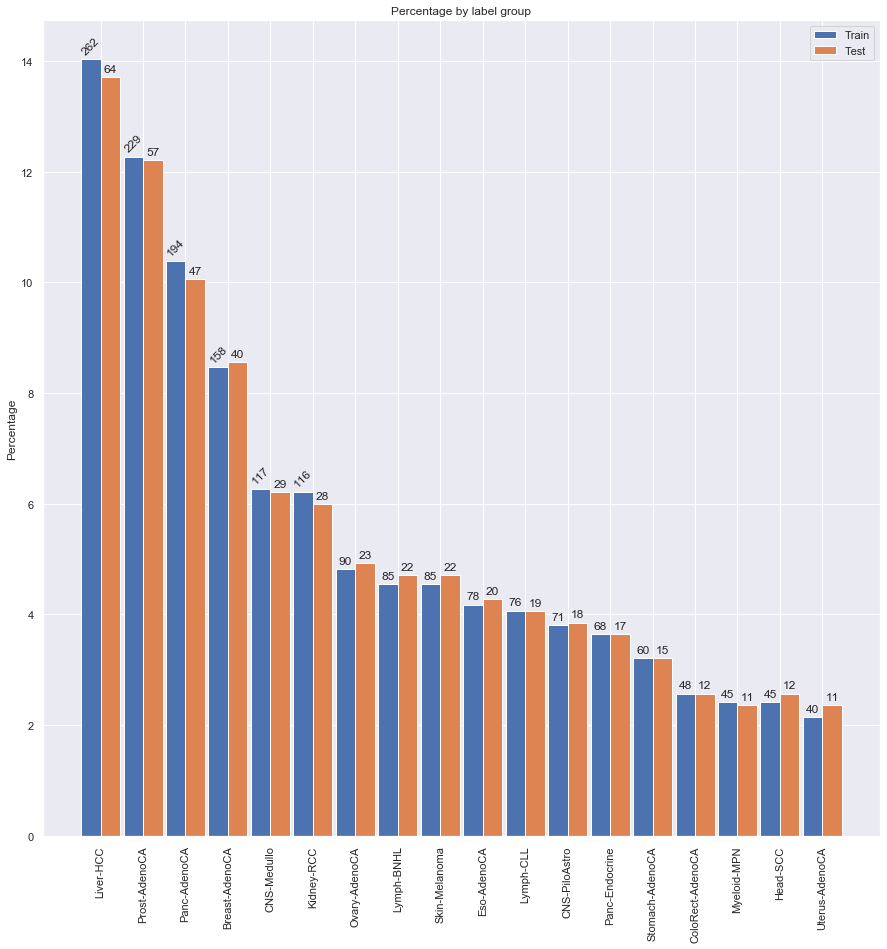

In [187]:
npr.seed(0)
raw_tasks = sum([[Task(dataset.X_96, dataset.Y_t), Task(dataset.X_96, dataset.Y_r), Task(dataset.X_96, dataset.Y_c)] for dataset in Datasets], [])
# t1 = raw_tasks[2]
t1 = raw_tasks[2].cutoff_rare(50)
t1.X = np.log(t1.X + 1)
t1t, t1v = t1.split()
PlotLabelSplit(t1t, t1v)
t1n, (t1tn, t1vn) = Normalizer.normalize_all_task(t1t, t1v)

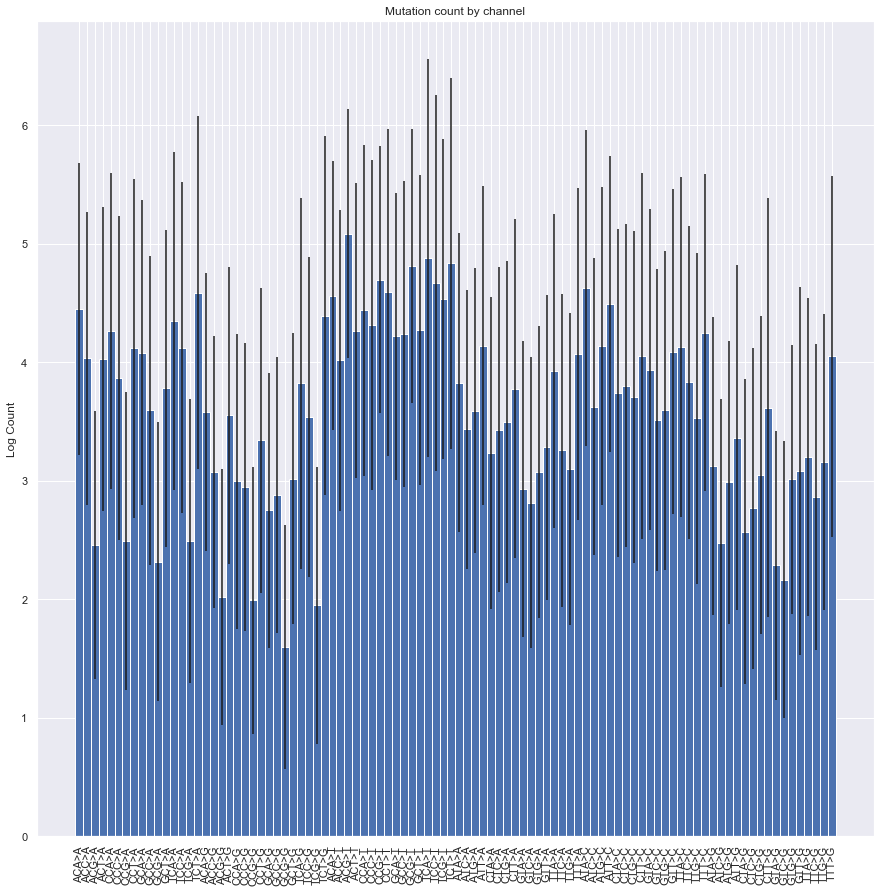

In [188]:
# view average mutation count
plt.figure(figsize = [15, 15])
xn = Normalizer(np.log(raw_tasks[0].X + 1))
N = len(xn.X_mean)
ids = np.arange(N)
plt.bar(ids, xn.X_mean[:N], width = 1.0, yerr = xn.X_std[:N])
# for i in range(N):
#     print(i, channel_names[i], xn.X_mean[i], xn.X_std[i])

plt.ylabel('Log Count')
plt.title('Mutation count by channel')
plt.xticks(ids, channel_names, rotation='vertical')

plt.show()

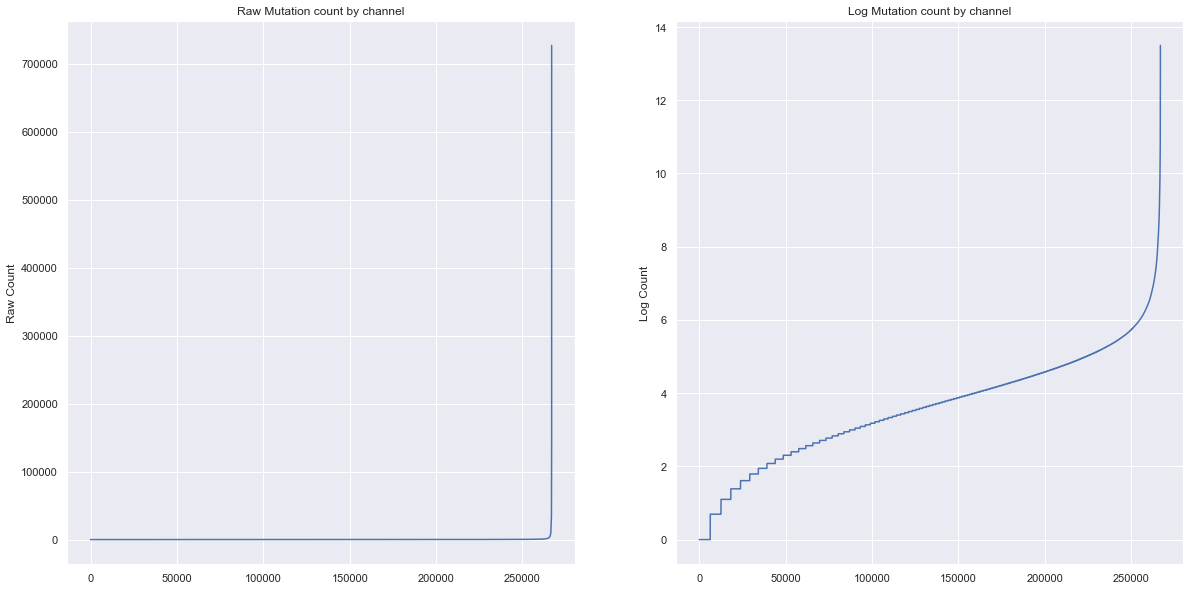

In [189]:
Xs = raw_tasks[0].X.flatten()
plt.figure(figsize = [20, 10])
plt.subplot(121)
plt.plot(sorted(Xs))
plt.ylabel('Raw Count')
plt.title('Raw Mutation count by channel')
plt.subplot(122)
Xs = np.log(Xs + 1)
plt.plot(sorted(Xs))
plt.ylabel('Log Count')
plt.title('Log Mutation count by channel')


plt.show()

In [190]:
class PCAEmbedding:
    def __init__(self, X, m):
        self.X = X
        self.m = m
        self.n = self.X.shape[0]
        C = self.X.T @ self.X / self.n
        self.u, self.s, self.vh = np.linalg.svd(C, full_matrices = True)
    def embed(self, X, m = None):
        return X @ self.u[:, :(self.m if m == None else m)]
    @staticmethod
    def embed_X(X, m):
        pca = PCAEmbedding(X, m)
        return pca, pca.embed(X)

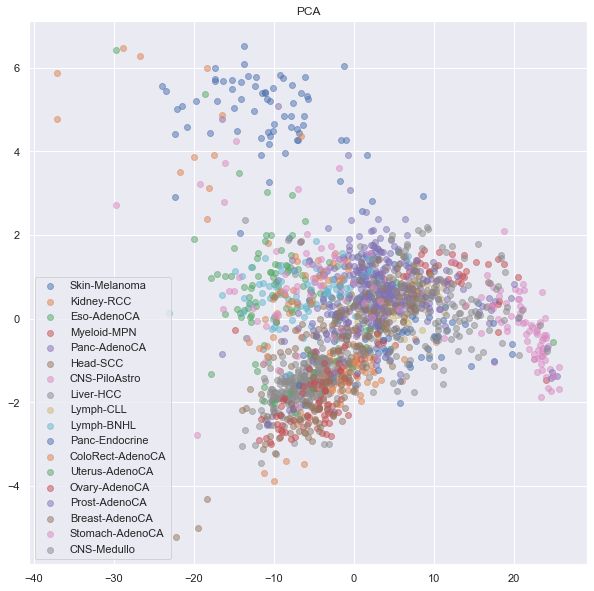

In [191]:
pca, Xs = PCAEmbedding.embed_X(t1tn.X, 2)
plt.figure(figsize = [10, 10])
for name in set(t1tn.Y):
    I = t1tn.Y == name
    plt.scatter(Xs[I][:, 0], Xs[I][:, 1], alpha=0.5, label = name)
plt.legend()
plt.title("PCA")
plt.show()

In [192]:
X = t1tn.X
Y = t1tn.Y
X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)

(1867, 2)


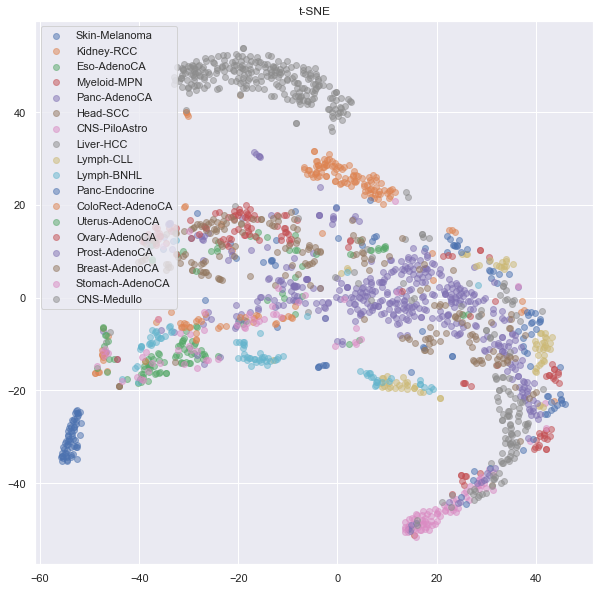

In [193]:
plt.figure(figsize = [10, 10])
for name in set(Y):
    I = Y == name
    plt.scatter(X_embedded[I, 0], X_embedded[I, 1], alpha=0.5, label = name)
plt.legend()
plt.title("t-SNE")
plt.show()

In [194]:
X_em = sklearn.manifold.TSNE(n_components=2).fit_transform(PCAEmbedding.embed_X(t1tn.X, 30)[1])
print(X_em.shape)

(1867, 2)


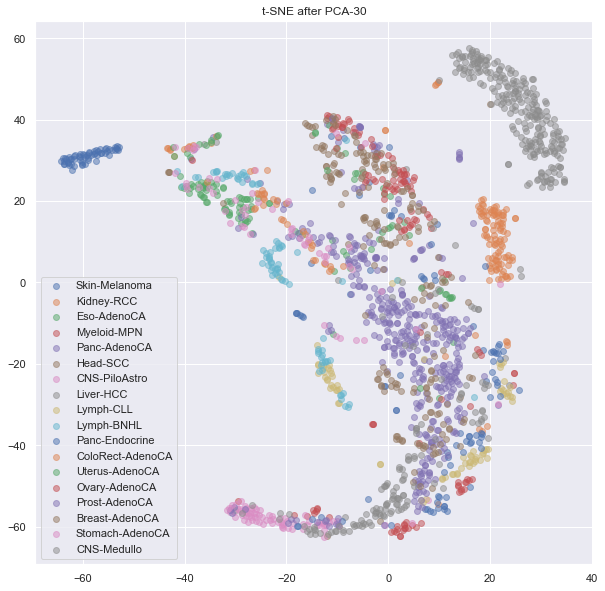

In [195]:
plt.figure(figsize = [10, 10])
for name in set(Y):
    I = Y == name
    plt.scatter(X_em[I, 0], X_em[I, 1], alpha=0.5, label = name)
plt.legend()
plt.title("t-SNE after PCA-30")
plt.show()

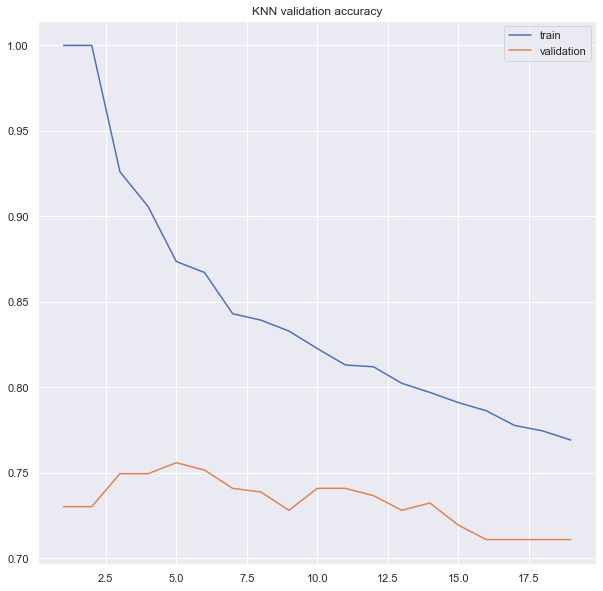

0.7558886509635975 5


In [196]:
class KNN:
    def __init__(self, X, Y, k):
        self.k = k
        self.X = X
        self.Y = Y
    def predict(self, X):
        ds = np.sum((self.X - X) ** 2, axis = 1)
        ids = np.argsort(ds)[:self.k]
        return Counter(self.Y[ids]).most_common()[0][0]
    def predict_all(self, X):
        return np.array([self.predict(X[i]) for i in range(X.shape[0])])

P = 0
Ks, valid_accs, train_accs = [], [], []
if P > 0:
    pca, TXp = PCAEmbedding.embed_X(t1tn.X, P)
    VXp = pca.embed(t1vn.X, P)
else:
    TXp, VXp = t1tn.X, t1vn.X
for K in range(1, 20):
    knn = KNN(TXp, t1tn.Y, K)
    c, t = defaultdict(int), defaultdict(int)
    tc = 0
    y_pred = knn.predict_all(VXp)
    acc = t1vn.evaluate(y_pred)
    valid_accs.append(acc)
    train_accs.append(t1tn.evaluate(knn.predict_all(TXp)))
    # for i in range(t1vn.n):
    #     t[t1vn.Y[i]] += 1
    #     y = knn.predict(VXp[i])
    #     if y[0] == t1vn.Y[i]:
    #         c[t1vn.Y[i]] += 1
    #         tc += 1
    # if K == 6:
    #     for name in t:
    #         print('%15s'%name, '%5d'%c[name], '%5d'%t[name], '%.1f%%' % (c[name] / t[name] * 100))
    Ks.append(K)
    # accs.append(tc / NTest)

plt.figure(figsize = [10, 10])
plt.title("KNN validation accuracy")
plt.plot(Ks, train_accs, label="train")
plt.plot(Ks, valid_accs, label="validation")
plt.legend()
plt.show()
print(np.max(valid_accs), Ks[np.argmax(valid_accs)])

In [197]:
# def PlotConfusionMatrix(confusion):
#     n, m = confusion.shape
#     # normalized
#     norm = confusion / np.sum(confusion, axis = 1)[:, None]
#     df_cm = pd.DataFrame(array, index = [i for i in "ABCDEFGHIJK"],
#                   columns = [str(i) for i in range(len("ABCDEFGHIJK"))])
#     plt.figure(figsize = (10,7))
#     sn.heatmap(df_cm, annot=True)

# LightGBM

In [200]:
# LightGBM Classifier
from lightgbm import LGBMClassifier

In [201]:
lgbm = LGBMClassifier(objective='multiclass', random_state=5)
lgbm.fit(t1tn.X, t1tn.Y)
y_pred = lgbm.predict(t1vn.X)

In [202]:
t1vn.evaluate(y_pred)

0.7965738758029979

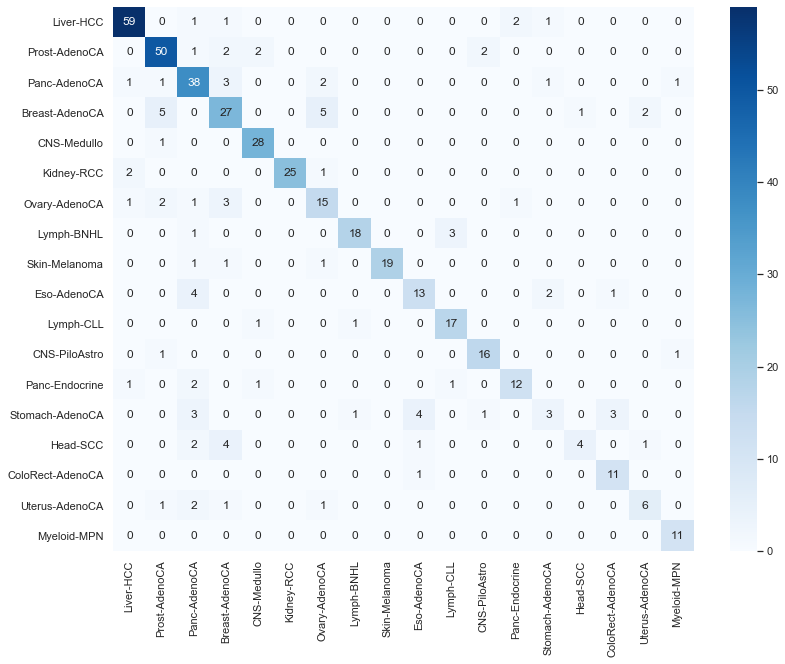

In [203]:
from string import ascii_uppercase
from pandas import DataFrame
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

labels = [label for label, count in Counter(t1vn.Y).most_common()]

confm = confusion_matrix(t1vn.Y, y_pred, labels=labels)
df = DataFrame(confm, index=labels, columns=labels)

f, ax = plt.subplots(figsize=(13, 10))
ax = sn.heatmap(df, cmap='Blues', annot=True)
# ax.figure(figsize = [10, 10])


# Multi Layer Percepton - PyTorch

In [ ]:
import torch
labels = [label for label, count in Counter(t1vn.Y).most_common()]
def labels_to_int(Y):
    return np.array([labels.index(y) for y in Y])
x_train = torch.tensor(t1tn.X, dtype=torch.float)
y_train = torch.tensor(labels_to_int(t1tn.Y))
x_valid = torch.tensor(t1vn.X, dtype=torch.float)
y_valid = torch.tensor(labels_to_int(t1vn.Y))
from torch.utils.data import TensorDataset
trainset = TensorDataset(x_train, y_train)
validset = TensorDataset(x_valid, y_valid)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

import torch.nn as nn
import torch.nn.functional as F
model = nn.Sequential(
        nn.Linear(96, 50),
        nn.BatchNorm1d(50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.BatchNorm1d(50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.BatchNorm1d(50),
        nn.ReLU(),
        nn.Linear(50, len(labels)),   
        )
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
l1_crit = nn.L1Loss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

train_accs = []
valid_accs = []
for epoch in range(200):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # loss = sum([l1_crit(param) * 0.0005 for param in model.parameters()], loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_acc = accuracy(model(trainset[:][0]), trainset[:][1])
    valid_acc = accuracy(model(validset[:][0]), validset[:][1])
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    if (epoch + 1) % 20 == 0:
        print('epoch %d loss: %.3f, acc: %.3f, validation acc: %.3f' % (epoch + 1, running_loss / (i+1), train_acc, valid_acc))

plt.figure(figsize = [10, 10])
plt.plot(train_accs, label="train")
plt.plot(valid_accs, label="valid")
plt.legend()
plt.title("MLP-3")
plt.show()

In [ ]:
class ResNet(nn.Module):
    def __init__(self, module):
        super(ResNet, self).__init__()
        self.module = module
    def forward(self, inputs):
        return self.module(inputs) + inputs
model = nn.Sequential(
        nn.Linear(96, 50),
        ResNet(nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            )),
        ResNet(nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            )),
        ResNet(nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            )),
        nn.Linear(50, len(labels)),   
        )
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
l1_crit = nn.L1Loss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

train_accs = []
valid_accs = []
for epoch in range(200):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_acc = accuracy(model(trainset[:][0]), trainset[:][1])
    valid_acc = accuracy(model(validset[:][0]), validset[:][1])
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    if (epoch + 1) % 20 == 0:
        print('epoch %d loss: %.3f, acc: %.3f, validation acc: %.3f' % (epoch + 1, running_loss / (i+1), train_acc, valid_acc))

plt.figure(figsize = [10, 10])
plt.plot(train_accs, label="train")
plt.plot(valid_accs, label="valid")
plt.legend()
plt.title("MLP-3")
plt.show()